In [5]:
!pip install pandas matplotlib ultralytics opencv-python albumentations numpy pyyaml pathlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [1]:
# prompt: mount data folder from google drive located ../data from the current location

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/dlbs-mc-oliver-fabian/data')

Mounted at /content/drive


In [6]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import glob
import xml.etree.ElementTree as ET
import cv2
from pathlib import Path
import matplotlib.image as mpimg
import albumentations as A
import numpy as np
import random
import yaml

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def get_augmentation():
    """
    Standard Augmentationen für YOLO
    """
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.8, 1.2), translate_percent=(-0.1, 0.1), rotate=(-15, 15), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
        A.OneOf([
            A.GaussNoise(p=1.0),
            A.GaussianBlur(blur_limit=3, p=1.0),
        ], p=0.2),
    ], bbox_params=A.BboxParams(
        format='yolo',
        label_fields=['class_labels'],
        min_visibility=0.3
    ))

def parse_yolo_txt(txt_path):
    """
    Parst YOLO .txt Datei
    """
    bboxes = []
    class_labels = []

    if not os.path.exists(txt_path):
        return bboxes, class_labels

    with open(txt_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                bboxes.append([x_center, y_center, width, height])
                class_labels.append(class_id)

    return bboxes, class_labels

def save_yolo_txt(output_path, bboxes, class_labels):
    """
    Speichert YOLO .txt Datei
    """
    with open(output_path, 'w') as f:
        for bbox, class_label in zip(bboxes, class_labels):
            x_center, y_center, width, height = bbox
            f.write(f"{class_label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def augment_dataset(input_dir, output_dir, num_augmentations=3):
    """
    Augmentiert YOLO Dataset mit images/ und labels/ Struktur
    """
    # Erstelle Output-Ordnerstruktur
    output_images_dir = os.path.join(output_dir, 'images')
    output_labels_dir = os.path.join(output_dir, 'labels')
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    transform = get_augmentation()

    # Input-Ordner
    input_images_dir = os.path.join(input_dir, 'images')
    input_labels_dir = os.path.join(input_dir, 'labels')

    # Finde alle Bilder im images/ Ordner
    images = glob.glob(os.path.join(input_images_dir, '*.jpg')) + glob.glob(os.path.join(input_images_dir, '*.png'))

    for image_path in images:
        # Entsprechende .txt Datei im labels/ Ordner finden
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        txt_path = os.path.join(input_labels_dir, base_name + '.txt')

        # Lade Bild
        image = cv2.imread(image_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Lade Annotations
        bboxes, class_labels = parse_yolo_txt(txt_path)

        if not bboxes:
            print(f"Keine Labels für {os.path.basename(image_path)}")
            continue

        # Kopiere Original
        original_name = os.path.basename(image_path)
        original_txt_name = base_name + '.txt'

        # Original Bild in output/images/
        cv2.imwrite(
            os.path.join(output_images_dir, original_name),
            cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        )

        # Original Label in output/labels/
        if os.path.exists(txt_path):
            save_yolo_txt(
                os.path.join(output_labels_dir, original_txt_name),
                bboxes,
                class_labels
            )

        # Erstelle Augmentationen
        for i in range(num_augmentations):
            try:
                transformed = transform(
                    image=image,
                    bboxes=bboxes,
                    class_labels=class_labels
                )

                if len(transformed['bboxes']) > 0:
                    base_filename = os.path.splitext(original_name)[0]
                    ext = os.path.splitext(original_name)[1]

                    aug_image_name = f"{base_filename}_aug{i}{ext}"
                    aug_txt_name = f"{base_filename}_aug{i}.txt"

                    # Augmentiertes Bild in output/images/
                    aug_image_path = os.path.join(output_images_dir, aug_image_name)
                    cv2.imwrite(
                        aug_image_path,
                        cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
                    )

                    # Augmentiertes Label in output/labels/
                    aug_txt_path = os.path.join(output_labels_dir, aug_txt_name)
                    save_yolo_txt(
                        aug_txt_path,
                        transformed['bboxes'],
                        transformed['class_labels']
                    )

                    print(f"Erstellt: {aug_image_name}")

            except Exception as e:
                print(f"Fehler bei {image_path}, Augmentation {i}: {e}")
                continue

In [ ]:
!ls ../data

test  train  valid


In [ ]:
dog_aliases = {'Abrador', 'Chihuahua', 'Shiba-Inu'}

base_dir = '../data'

for split in ['train', 'valid', 'test']:
    split_dir = os.path.join(base_dir, split)
    if not os.path.isdir(split_dir):
        continue

    xml_paths = glob.glob(os.path.join(split_dir, '*.xml'))
    for xml_path in xml_paths:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        modified = False

        for obj in root.findall('object'):
            name_elem = obj.find('name')
            if name_elem is not None and name_elem.text in dog_aliases:
                name_elem.text = 'dog'
                modified = True

        if modified:
            tree.write(xml_path, encoding='utf-8', xml_declaration=True)
            print(f"Updated: {xml_path}")

In [ ]:
def create_subset(src_root='../../data', dst_root='../../data_small',
                  n_train=100, n_val=50, splits=('train','valid')):
    for split, n in zip(splits, (n_train, n_val)):
        src_dir = os.path.join(src_root, split)
        dst_dir = os.path.join(dst_root, split)

        # Erstelle YOLO-konforme Ordnerstruktur
        images_dir = os.path.join(dst_dir, 'images')
        labels_dir = os.path.join(dst_dir, 'labels')
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)

        imgs = glob.glob(f"{src_dir}/*.jpg") + glob.glob(f"{src_dir}/*.png")
        if len(imgs) < n:
            print(f"Nur {len(imgs)} Bilder in {split}, nutze alle.")
            sample = imgs
        else:
            sample = random.sample(imgs, n)

        for img in sample:
            base = os.path.basename(img)
            name, _ = os.path.splitext(base)
            txt = os.path.join(src_dir, name + '.txt')

            # Kopiere Bild in images/ Ordner
            shutil.copy(img, os.path.join(images_dir, base))

            # Kopiere Label in labels/ Ordner
            if os.path.isfile(txt):
                shutil.copy(txt, os.path.join(labels_dir, name + '.txt'))
            else:
                print(f"Warnung: Label für {base} fehlt!")

create_subset(
    src_root='../data',
    dst_root='../data_small',
    n_train=100,
    n_val=50
)


augment_dataset('../data_small/train', '../data_small/train_augmented', num_augmentations=3)

In [ ]:
# Lösche Cache
print("Lösche Cache-Dateien...")
cache_files = glob.glob('../data_small/**/*.cache', recursive=True)
for cache in cache_files:
    os.remove(cache)
    print(f"Gelöscht: {cache}")

# Korrigiere Klassen-IDs
print("\nKorrigiere Klassen-IDs...")
def fix_class_ids(dataset_path):
    label_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.txt'):
                label_files.append(os.path.join(root, file))

    fixed_count = 0
    for txt_file in label_files:
        try:
            with open(txt_file, 'r') as f:
                lines = f.readlines()

            fixed_lines = []
            file_modified = False

            for line in lines:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 5:
                        if parts[0] != '0':
                            parts[0] = '0'
                            file_modified = True
                        fixed_lines.append(' '.join(parts))

            if file_modified:
                with open(txt_file, 'w') as f:
                    for line in fixed_lines:
                        f.write(line + '\n')
                fixed_count += 1

        except Exception as e:
            print(f"Fehler bei {txt_file}: {e}")

    print(f"{fixed_count} Dateien korrigiert!")

fix_class_ids('../data_small')

# Erstelle YAML
print("\nErstelle YAML...")
yaml_content = {
    'path': os.path.abspath('../data_small'),
    'train': 'train_augmented/images',
    'val': 'valid/images',
    'nc': 1,
    'names': ['dog']
}

with open('../data_small/dog_dataset.yaml', 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

# Teste ein Label
print("\nTeste korrigierte Labels...")
label_files = glob.glob('../data_small/**/labels/*.txt', recursive=True)
if label_files:
    with open(label_files[0], 'r') as f:
        first_line = f.readline().strip()
        print(f"Beispiel Label: {first_line}")


In [ ]:
# Training
print("\nStarte Training...")
model = YOLO('yolov8n.pt')
results = model.train(
    data='../data_small/dog_dataset.yaml',
    imgsz=640,
    epochs=20,
    batch=4,
    workers=2,
    project='runs',
    name='baseline_fixed',
    exist_ok=True
)


Starte Training...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_fixed, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 66.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.9±0.3 MB/s, size: 297.0 KB)


train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [02:42<00:00, 15.08it/s]


train: New cache created: /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.4 ms, read: 44.6±98.5 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:10<00:00, 22.98it/s]

val: New cache created: /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache


Plotting labels to runs/baseline_fixed/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/baseline_fixed
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.631G      1.441      2.182      1.612          5        640: 100%|██████████| 613/613 [00:53<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  8.64it/s]

                   all        231        249      0.688       0.55      0.626      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.756G      1.594      1.922      1.722          3        640: 100%|██████████| 613/613 [00:46<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]

                   all        231        249      0.708      0.652      0.741      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.773G      1.625       1.81      1.749          4        640: 100%|██████████| 613/613 [00:46<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.42it/s]

                   all        231        249      0.717      0.671      0.719       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.789G      1.576      1.738      1.722          1        640: 100%|██████████| 613/613 [00:46<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.70it/s]

                   all        231        249      0.688      0.647      0.695      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.807G      1.515      1.597       1.67          6        640: 100%|██████████| 613/613 [00:46<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]

                   all        231        249      0.763      0.763      0.808      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.824G      1.444      1.463      1.608          4        640: 100%|██████████| 613/613 [00:46<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]

                   all        231        249      0.751      0.765      0.781      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.842G      1.388      1.369      1.557          8        640: 100%|██████████| 613/613 [00:46<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]

                   all        231        249      0.854      0.752      0.868      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.859G      1.355      1.288      1.538          7        640: 100%|██████████| 613/613 [00:46<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.64it/s]

                   all        231        249      0.868      0.831      0.864       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.875G      1.313       1.23      1.501          4        640: 100%|██████████| 613/613 [00:46<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.54it/s]

                   all        231        249      0.846      0.803      0.849      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.893G      1.273      1.188      1.482          3        640: 100%|██████████| 613/613 [00:46<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.65it/s]

                   all        231        249      0.858      0.799      0.884      0.625


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.908G      1.199     0.9498      1.464          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]

                   all        231        249      0.863      0.863        0.9      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.922G      1.166     0.9122      1.423          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.43it/s]

                   all        231        249      0.919      0.821      0.904      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.943G      1.144     0.8339      1.414          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.85it/s]

                   all        231        249      0.861      0.839      0.907      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.959G      1.086     0.7976      1.377          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]

                   all        231        249      0.876      0.882      0.928      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.977G      1.056     0.7305      1.332          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]

                   all        231        249      0.931      0.859       0.94      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.994G      1.022      0.696      1.329          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.84it/s]

                   all        231        249      0.901      0.879      0.946      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.01G     0.9816     0.6456      1.283          3        640: 100%|██████████| 613/613 [00:46<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.41it/s]

                   all        231        249      0.921       0.88      0.947      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.03G     0.9436     0.6116      1.257          3        640: 100%|██████████| 613/613 [00:46<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.33it/s]

                   all        231        249       0.93      0.852      0.953      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.04G     0.9012     0.5769      1.224          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.60it/s]

                   all        231        249      0.948      0.867      0.959      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.06G     0.8878     0.5607      1.221          3        640: 100%|██████████| 613/613 [00:46<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.68it/s]

                   all        231        249      0.913      0.916      0.966        0.7



20 epochs completed in 0.271 hours.
Optimizer stripped from runs/baseline_fixed/weights/last.pt, 6.2MB
Optimizer stripped from runs/baseline_fixed/weights/best.pt, 6.2MB

Validating runs/baseline_fixed/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.78it/s]


                   all        231        249      0.913      0.916      0.966      0.701
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/baseline_fixed


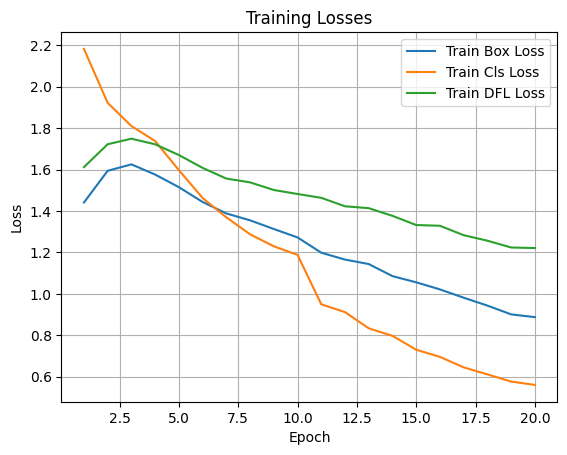

In [ ]:
%matplotlib inline
df = pd.read_csv('./runs/baseline_fixed/results.csv')

# Nach Epoche gruppieren und Mittelwert berechnen
grouped = df.groupby('epoch').mean(numeric_only=True)

# Plotten
plt.figure()
plt.plot(grouped.index, grouped['train/box_loss'], label='Train Box Loss')
plt.plot(grouped.index, grouped['train/cls_loss'], label='Train Cls Loss')
plt.plot(grouped.index, grouped['train/dfl_loss'], label='Train DFL Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend(); plt.grid(True)
plt.show()

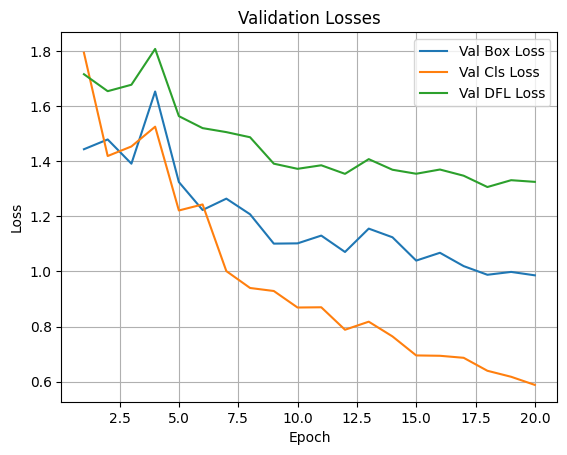

In [ ]:
# Mittelwert pro Epoche berechnen
grouped = df.groupby('epoch').mean(numeric_only=True)

# Plotten der validierungsverluste
plt.figure()
plt.plot(grouped.index, grouped['val/box_loss'], label='Val Box Loss')
plt.plot(grouped.index, grouped['val/cls_loss'], label='Val Cls Loss')
plt.plot(grouped.index, grouped['val/dfl_loss'], label='Val DFL Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend(); plt.grid(True)
plt.show()

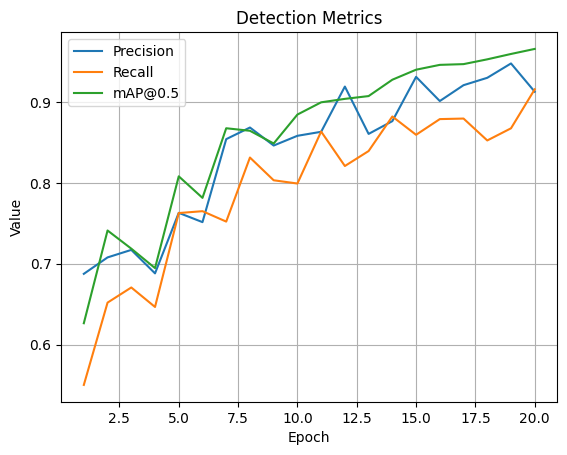

In [ ]:
# Gruppieren nach Epoche und Mittelwert bilden
grouped = df.groupby('epoch').mean(numeric_only=True)

# Detection Metrics plotten
plt.figure()
plt.plot(grouped.index, grouped['metrics/precision(B)'], label='Precision')
plt.plot(grouped.index, grouped['metrics/recall(B)'], label='Recall')
plt.plot(grouped.index, grouped['metrics/mAP50(B)'], label='mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics')
plt.legend(); plt.grid(True)
plt.show()

In [ ]:
# Finde alle PNG-Dateien im Run-Ordner
images = glob.glob('./runs/baseline_fixed/*.png') + glob.glob('./runs/baseline_fixed/*.jpg')
print(f"Gefundene Bilder: {[os.path.basename(img) for img in images]}")

# Zeige alle in einem Grid
if images:
    n = len(images)
    cols = 3
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 5*rows))
    for i, img_path in enumerate(images):
        plt.subplot(rows, cols, i+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(os.path.basename(img_path), fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Keine Bilder gefunden!")


Output hidden; open in https://colab.research.google.com to view.

## Overfit

### Komplexität steigern
1. Wechsel zu Small Modell

In [ ]:
model = YOLO('yolov8s.pt')
results = model.train(
    data='../data_small/dog_dataset.yaml',
    imgsz=640,
    epochs=20,
    batch=4,
    workers=2,
    project='runs',
    name='yolo_small',
    exist_ok=True
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 164MB/s]


Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_small, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 189.9±83.4 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/yolo_small/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/yolo_small
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.33G      1.535      1.977      1.726          5        640: 100%|██████████| 613/613 [00:51<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.76it/s]

                   all        231        249       0.56      0.635       0.58       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.73G      1.725      1.921      1.869          3        640: 100%|██████████| 613/613 [00:47<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.17it/s]


                   all        231        249      0.647       0.55      0.596      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.73G      1.693      1.843       1.84          4        640: 100%|██████████| 613/613 [00:49<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]

                   all        231        249      0.724      0.581      0.629      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.73G      1.639        1.8      1.801          1        640: 100%|██████████| 613/613 [00:49<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]

                   all        231        249      0.675      0.599      0.658      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.73G       1.57      1.637      1.744          6        640: 100%|██████████| 613/613 [00:48<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.52it/s]

                   all        231        249      0.686      0.772       0.79      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.73G      1.499      1.495      1.682          4        640: 100%|██████████| 613/613 [00:49<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.68it/s]

                   all        231        249      0.818      0.793      0.843      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.73G      1.431      1.404      1.617          8        640: 100%|██████████| 613/613 [00:49<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.58it/s]

                   all        231        249      0.818      0.797       0.87      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.73G      1.411      1.354      1.618          7        640: 100%|██████████| 613/613 [00:49<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.98it/s]

                   all        231        249      0.798      0.795      0.853      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.73G      1.346      1.268       1.56          4        640: 100%|██████████| 613/613 [00:47<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.33it/s]

                   all        231        249      0.806       0.82      0.849      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.73G      1.294      1.201      1.529          3        640: 100%|██████████| 613/613 [00:48<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]

                   all        231        249      0.846      0.815      0.872        0.6


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.73G      1.246     0.9922      1.531          2        640: 100%|██████████| 613/613 [00:49<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.51it/s]

                   all        231        249      0.923      0.799      0.895      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.73G      1.199     0.8968      1.486          2        640: 100%|██████████| 613/613 [00:48<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.37it/s]

                   all        231        249      0.917      0.815      0.892      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.73G      1.165     0.8303      1.461          2        640: 100%|██████████| 613/613 [00:48<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.26it/s]

                   all        231        249      0.909      0.847      0.916      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.73G      1.099     0.7774      1.419          2        640: 100%|██████████| 613/613 [00:49<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.78it/s]

                   all        231        249      0.926      0.855      0.937      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.73G      1.058     0.7126      1.368          2        640: 100%|██████████| 613/613 [00:49<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.15it/s]

                   all        231        249      0.924      0.827      0.928      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.73G      1.012     0.6794      1.344          2        640: 100%|██████████| 613/613 [00:49<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]

                   all        231        249      0.908      0.888      0.943      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.73G     0.9667     0.6346      1.292          3        640: 100%|██████████| 613/613 [00:49<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]

                   all        231        249      0.886      0.888      0.937      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.73G     0.9415     0.5957      1.277          3        640: 100%|██████████| 613/613 [00:49<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.48it/s]

                   all        231        249      0.916      0.871       0.94      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.73G     0.8884     0.5536      1.235          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]

                   all        231        249      0.949      0.899      0.963      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.73G     0.8555     0.5301      1.216          3        640: 100%|██████████| 613/613 [00:50<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]

                   all        231        249      0.906      0.932      0.963      0.707



20 epochs completed in 0.287 hours.
Optimizer stripped from runs/yolo_small/weights/last.pt, 22.5MB
Optimizer stripped from runs/yolo_small/weights/best.pt, 22.5MB

Validating runs/yolo_small/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


                   all        231        249      0.949        0.9      0.962      0.709
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/yolo_small


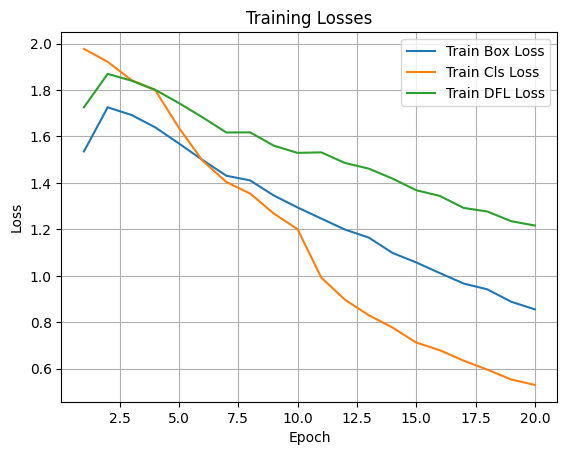

In [ ]:
%matplotlib inline
df = pd.read_csv('./runs/yolo_small/results.csv')

plt.figure()
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend(); plt.grid(True)
plt.show()

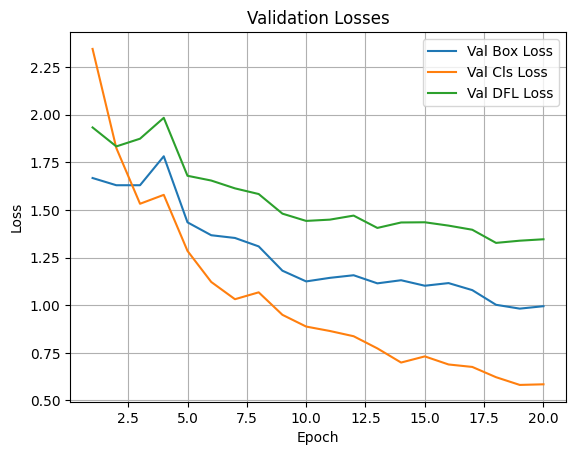

In [ ]:
plt.figure()
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend(); plt.grid(True)
plt.show()

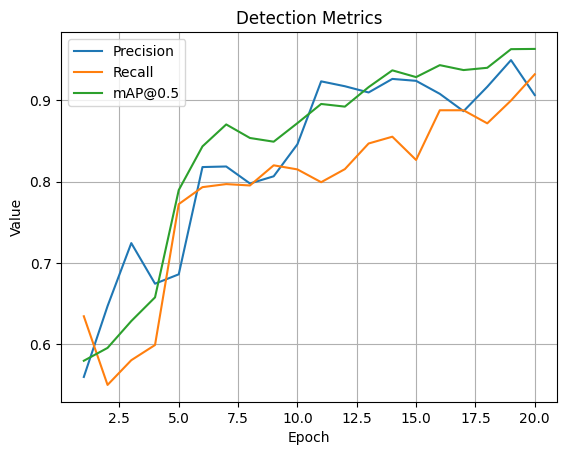

In [ ]:
plt.figure()
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics')
plt.legend(); plt.grid(True)
plt.show()

In [ ]:
# Finde alle PNG-Dateien im Run-Ordner
images = glob.glob('./runs/yolo_small/*.png') + glob.glob('./runs/yolo_small/*.jpg')
print(f"Gefundene Bilder: {[os.path.basename(img) for img in images]}")

# Zeige alle in einem Grid
if images:
    n = len(images)
    cols = 3
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 5*rows))
    for i, img_path in enumerate(images):
        plt.subplot(rows, cols, i+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(os.path.basename(img_path), fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Keine Bilder gefunden!")


Output hidden; open in https://colab.research.google.com to view.

2. Training mit Bildgrössenvarianz

In [ ]:
image_sizes = [320, 416, 512, 640, 832]

for size in image_sizes:
    print(f"Training mit Bildgröße: {size}")
    model = YOLO('yolov8s.pt')
    results = model.train(
        data='../data_small/dog_dataset.yaml',
        batch=4,
        workers=2,
        imgsz=size,
        epochs=20,
        name=f'multiscale_{size}',
        exist_ok=True
    )

Training mit Bildgröße: 320
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=multiscale_320, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 130.6±86.4 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/multiscale_320/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/multiscale_320
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.688G      1.536      1.678      1.539          5        320: 100%|██████████| 613/613 [00:50<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.47it/s]


                   all        231        249      0.622      0.635      0.625       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.688G      1.697      1.701      1.657          3        320: 100%|██████████| 613/613 [00:46<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.39it/s]

                   all        231        249      0.649      0.594      0.643      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.688G      1.647      1.651      1.636          4        320: 100%|██████████| 613/613 [00:46<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]

                   all        231        249      0.751      0.663      0.713      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.688G      1.593      1.573      1.604          1        320: 100%|██████████| 613/613 [00:48<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]

                   all        231        249      0.671      0.663      0.703      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.688G       1.54      1.449      1.563          6        320: 100%|██████████| 613/613 [00:46<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.44it/s]

                   all        231        249      0.773      0.679      0.731      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.689G      1.473      1.355      1.508          4        320: 100%|██████████| 613/613 [00:48<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.26it/s]

                   all        231        249      0.761      0.735      0.788      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.744G      1.413      1.247      1.465          8        320: 100%|██████████| 613/613 [00:48<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.48it/s]

                   all        231        249       0.76      0.787      0.807      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.744G      1.385      1.215      1.452          7        320: 100%|██████████| 613/613 [00:48<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.45it/s]

                   all        231        249      0.792      0.782      0.801      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.744G      1.336      1.119      1.418          4        320: 100%|██████████| 613/613 [00:49<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.94it/s]

                   all        231        249      0.834      0.803      0.844      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.744G      1.305      1.106      1.399          3        320: 100%|██████████| 613/613 [00:49<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.61it/s]

                   all        231        249      0.815      0.835      0.848      0.545


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.744G      1.212     0.9014      1.341          2        320: 100%|██████████| 613/613 [00:49<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]

                   all        231        249      0.796      0.823      0.832      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.744G      1.181     0.8265      1.318          2        320: 100%|██████████| 613/613 [00:48<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]

                   all        231        249      0.861      0.815      0.854      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.744G      1.131     0.7654      1.284          2        320: 100%|██████████| 613/613 [00:48<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.05it/s]

                   all        231        249      0.859      0.771      0.827      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.744G      1.095      0.727      1.254          2        320: 100%|██████████| 613/613 [00:46<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.61it/s]

                   all        231        249      0.849      0.857      0.863      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.744G       1.05     0.6777      1.217          2        320: 100%|██████████| 613/613 [00:48<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.88it/s]

                   all        231        249      0.865      0.827      0.852      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.744G      1.018     0.6442      1.203          2        320: 100%|██████████| 613/613 [00:47<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.80it/s]

                   all        231        249      0.867      0.827      0.876      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.799G     0.9984     0.6073      1.187          3        320: 100%|██████████| 613/613 [00:48<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.98it/s]

                   all        231        249      0.836      0.855      0.884      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.801G     0.9429      0.561      1.156          3        320: 100%|██████████| 613/613 [00:47<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]

                   all        231        249       0.86      0.838      0.879      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.801G     0.9097     0.5334       1.13          2        320: 100%|██████████| 613/613 [00:48<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.92it/s]

                   all        231        249      0.887      0.851      0.887      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.801G     0.8857     0.5097      1.115          3        320: 100%|██████████| 613/613 [00:48<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.65it/s]

                   all        231        249      0.916      0.833      0.888      0.631



20 epochs completed in 0.281 hours.
Optimizer stripped from runs/detect/multiscale_320/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/multiscale_320/weights/best.pt, 22.5MB

Validating runs/detect/multiscale_320/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


                   all        231        249      0.887      0.851      0.887      0.643
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/multiscale_320
Training mit Bildgröße: 416
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 197.2±72.9 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/multiscale_416/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/multiscale_416
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.836G       1.51      1.764      1.604          5        416: 100%|██████████| 613/613 [00:49<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.41it/s]

                   all        231        249       0.59      0.622      0.633      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.904G      1.674      1.748      1.713          3        416: 100%|██████████| 613/613 [00:47<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]

                   all        231        249      0.636      0.554      0.619      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.904G       1.65      1.711      1.703          4        416: 100%|██████████| 613/613 [00:48<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.04it/s]

                   all        231        249      0.709      0.606      0.638      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.912G      1.613      1.663      1.666          1        416: 100%|██████████| 613/613 [00:48<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]

                   all        231        249      0.673      0.635       0.67      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.934G      1.536      1.527      1.603          6        416: 100%|██████████| 613/613 [00:47<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.64it/s]

                   all        231        249      0.819      0.675      0.759      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.934G      1.462      1.378      1.554          4        416: 100%|██████████| 613/613 [00:48<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.64it/s]

                   all        231        249      0.761      0.754      0.764      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.947G      1.424      1.321       1.53          8        416: 100%|██████████| 613/613 [00:47<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.30it/s]

                   all        231        249      0.829      0.781      0.808      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.984G      1.373      1.226      1.489          7        416: 100%|██████████| 613/613 [00:48<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.73it/s]

                   all        231        249      0.835      0.734      0.831       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.01G      1.319      1.149      1.447          4        416: 100%|██████████| 613/613 [00:48<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]

                   all        231        249      0.812      0.783      0.821      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.01G      1.284      1.128      1.437          2        416: 100%|██████████| 613/613 [00:49<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]

                   all        231        249      0.838      0.807      0.843      0.593


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.01G       1.19     0.8971      1.374          2        416: 100%|██████████| 613/613 [00:48<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.73it/s]

                   all        231        249      0.856      0.834      0.863      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.01G      1.168     0.8401      1.342          2        416: 100%|██████████| 613/613 [00:48<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.90it/s]

                   all        231        249      0.878      0.763      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.01G      1.126     0.7818      1.312          2        416: 100%|██████████| 613/613 [00:47<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.52it/s]

                   all        231        249      0.868      0.791      0.865      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.01G      1.071     0.7302      1.262          2        416: 100%|██████████| 613/613 [00:48<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.78it/s]

                   all        231        249      0.855      0.849      0.897      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.01G      1.039      0.682      1.257          2        416: 100%|██████████| 613/613 [00:48<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]

                   all        231        249      0.829      0.892      0.915      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.01G      1.003     0.6414      1.228          2        416: 100%|██████████| 613/613 [00:48<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.75it/s]


                   all        231        249        0.9      0.819      0.898      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.01G     0.9665     0.5959      1.198          3        416: 100%|██████████| 613/613 [00:47<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]

                   all        231        249      0.874      0.863      0.902      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.01G     0.9416     0.5603       1.18          3        416: 100%|██████████| 613/613 [00:48<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.50it/s]

                   all        231        249      0.893       0.87      0.909      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.01G     0.8803     0.5236      1.142          2        416: 100%|██████████| 613/613 [00:49<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.58it/s]

                   all        231        249      0.896      0.871      0.909      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.01G     0.8436     0.4956       1.12          3        416: 100%|██████████| 613/613 [00:48<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]

                   all        231        249      0.882      0.869      0.907      0.665



20 epochs completed in 0.283 hours.
Optimizer stripped from runs/detect/multiscale_416/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/multiscale_416/weights/best.pt, 22.5MB

Validating runs/detect/multiscale_416/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.70it/s]


                   all        231        249      0.882      0.869      0.905      0.664
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/multiscale_416
Training mit Bildgröße: 512
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 82.8±69.0 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/multiscale_512/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/multiscale_512
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.01G        1.5      1.811      1.635          5        512: 100%|██████████| 613/613 [00:51<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.45it/s]

                   all        231        249      0.636      0.666      0.679       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.23G      1.663      1.787       1.77          3        512: 100%|██████████| 613/613 [00:47<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.93it/s]

                   all        231        249      0.651      0.479      0.561       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.23G      1.662      1.778      1.762          4        512: 100%|██████████| 613/613 [00:48<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]

                   all        231        249      0.729      0.635      0.664      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.23G      1.611      1.709      1.714          1        512: 100%|██████████| 613/613 [00:48<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.61it/s]

                   all        231        249      0.716      0.667      0.706      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.23G      1.531      1.541      1.649          6        512: 100%|██████████| 613/613 [00:49<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.77it/s]

                   all        231        249      0.758      0.744      0.795      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.23G      1.481      1.442        1.6          4        512: 100%|██████████| 613/613 [00:49<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.73it/s]

                   all        231        249      0.832      0.814      0.848      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.24G       1.42      1.359      1.561          8        512: 100%|██████████| 613/613 [00:49<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]

                   all        231        249      0.836      0.799      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.26G      1.384      1.271      1.541          7        512: 100%|██████████| 613/613 [00:46<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.73it/s]


                   all        231        249       0.78      0.795      0.806      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.26G      1.327      1.179      1.491          4        512: 100%|██████████| 613/613 [00:47<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.80it/s]

                   all        231        249      0.832      0.795      0.838      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.26G      1.282      1.154      1.468          3        512: 100%|██████████| 613/613 [00:49<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]

                   all        231        249      0.875      0.807      0.863      0.581


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.26G      1.221     0.9214      1.436          2        512: 100%|██████████| 613/613 [00:48<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.46it/s]

                   all        231        249       0.85      0.803      0.851      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.26G      1.186     0.8634       1.42          2        512: 100%|██████████| 613/613 [00:48<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.47it/s]

                   all        231        249      0.864      0.799      0.868      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.26G      1.133     0.7902       1.36          2        512: 100%|██████████| 613/613 [00:50<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]

                   all        231        249      0.827      0.843       0.85      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.26G       1.09     0.7595       1.34          2        512: 100%|██████████| 613/613 [00:48<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]

                   all        231        249      0.881      0.827       0.87      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.26G       1.04     0.6843      1.298          2        512: 100%|██████████| 613/613 [00:48<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.56it/s]

                   all        231        249      0.881      0.864      0.898      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.26G     0.9938     0.6444      1.273          2        512: 100%|██████████| 613/613 [00:49<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.14it/s]

                   all        231        249      0.889      0.867       0.91      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.26G     0.9751     0.6121       1.25          3        512: 100%|██████████| 613/613 [00:49<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.50it/s]

                   all        231        249      0.909      0.863      0.907      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.26G     0.9309     0.5644      1.221          3        512: 100%|██████████| 613/613 [00:49<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]

                   all        231        249      0.917      0.851      0.913      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.27G     0.8866     0.5368      1.181          2        512: 100%|██████████| 613/613 [00:48<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]

                   all        231        249      0.876      0.908      0.939      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.31G     0.8635     0.5074      1.173          3        512: 100%|██████████| 613/613 [00:48<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]

                   all        231        249      0.902      0.867      0.916      0.693



20 epochs completed in 0.285 hours.
Optimizer stripped from runs/detect/multiscale_512/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/multiscale_512/weights/best.pt, 22.5MB

Validating runs/detect/multiscale_512/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.27it/s]


                   all        231        249      0.876      0.908      0.939      0.697
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/multiscale_512
Training mit Bildgröße: 640
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 162.8±41.7 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/multiscale_640/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/multiscale_640
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.37G      1.531      1.976      1.721          5        640: 100%|██████████| 613/613 [00:51<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.06it/s]

                   all        231        249      0.694      0.564      0.667      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.77G      1.722      1.945      1.875          3        640: 100%|██████████| 613/613 [00:49<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.17it/s]

                   all        231        249      0.674      0.574      0.646      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.77G        1.7      1.857      1.857          4        640: 100%|██████████| 613/613 [00:49<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]

                   all        231        249      0.727      0.578      0.672      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.77G      1.641      1.802      1.826          1        640: 100%|██████████| 613/613 [00:50<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]

                   all        231        249      0.613      0.606      0.662      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.77G      1.555      1.653      1.749          6        640: 100%|██████████| 613/613 [00:48<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.19it/s]


                   all        231        249      0.817      0.687      0.777      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.78G      1.477      1.501      1.666          4        640: 100%|██████████| 613/613 [00:50<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.78it/s]

                   all        231        249      0.822      0.722      0.786      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       1.8G      1.417      1.415       1.61          8        640: 100%|██████████| 613/613 [00:50<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.41it/s]

                   all        231        249      0.827      0.763      0.831      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       1.8G      1.382       1.32      1.601          7        640: 100%|██████████| 613/613 [00:49<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]


                   all        231        249      0.822      0.803      0.857      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       1.8G      1.333       1.26      1.555          4        640: 100%|██████████| 613/613 [00:50<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.54it/s]

                   all        231        249      0.811      0.747       0.81      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       1.8G        1.3      1.214       1.53          3        640: 100%|██████████| 613/613 [00:48<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.78it/s]

                   all        231        249      0.845      0.812      0.855      0.582


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       1.8G      1.246     0.9702      1.546          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.73it/s]

                   all        231        249       0.87      0.807      0.862       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       1.8G      1.193      0.896       1.48          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]

                   all        231        249      0.861      0.835      0.891      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       1.8G      1.156     0.8321      1.457          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.89it/s]

                   all        231        249      0.866      0.855      0.884      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       1.8G      1.108     0.7791      1.427          2        640: 100%|██████████| 613/613 [00:48<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.15it/s]

                   all        231        249      0.864      0.871      0.886      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       1.8G      1.055     0.7296      1.362          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]

                   all        231        249      0.863      0.851       0.91      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       1.8G      1.007     0.6877      1.337          2        640: 100%|██████████| 613/613 [00:49<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.66it/s]

                   all        231        249      0.918      0.851      0.921      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       1.8G     0.9901      0.635      1.307          3        640: 100%|██████████| 613/613 [00:49<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]

                   all        231        249        0.9      0.868      0.919      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       1.8G      0.942     0.5881      1.277          3        640: 100%|██████████| 613/613 [00:48<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.60it/s]

                   all        231        249      0.873       0.88      0.916      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       1.8G     0.8957     0.5578      1.243          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]

                   all        231        249      0.885      0.904       0.93      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       1.8G     0.8689      0.533      1.229          3        640: 100%|██████████| 613/613 [00:50<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.96it/s]

                   all        231        249      0.903      0.902      0.931      0.695



20 epochs completed in 0.290 hours.
Optimizer stripped from runs/detect/multiscale_640/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/multiscale_640/weights/best.pt, 22.5MB

Validating runs/detect/multiscale_640/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.23it/s]


                   all        231        249      0.903      0.902      0.931      0.695
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/multiscale_640
Training mit Bildgröße: 832
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=832, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 3.2±5.1 ms, read: 72.6±84.0 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/multiscale_832/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 832 train, 832 val
Using 2 dataloader workers
Logging results to runs/detect/multiscale_832
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.97G      1.564      2.164      1.855          5        832: 100%|██████████| 613/613 [00:52<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.66it/s]

                   all        231        249      0.422      0.606      0.411      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.62G      1.798      2.104      2.044          3        832: 100%|██████████| 613/613 [00:49<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.86it/s]

                   all        231        249      0.589      0.474      0.518      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.62G      1.784      2.036      2.027          4        832: 100%|██████████| 613/613 [00:51<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.23it/s]


                   all        231        249      0.593      0.542      0.569      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.62G      1.691      1.936       1.96          1        832: 100%|██████████| 613/613 [00:51<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.43it/s]

                   all        231        249      0.674      0.582      0.669      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.62G      1.604      1.784      1.876          6        832: 100%|██████████| 613/613 [00:51<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.75it/s]

                   all        231        249      0.771       0.73       0.77      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.64G      1.533       1.64      1.819          4        832: 100%|██████████| 613/613 [00:51<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]

                   all        231        249       0.58      0.635      0.586      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.67G      1.467      1.504      1.744          8        832: 100%|██████████| 613/613 [00:50<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.75it/s]

                   all        231        249      0.772      0.771      0.812      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.67G      1.445      1.434      1.731          7        832: 100%|██████████| 613/613 [00:51<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.63it/s]

                   all        231        249      0.758      0.775      0.811      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.67G      1.373      1.323      1.667          4        832: 100%|██████████| 613/613 [00:50<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.40it/s]

                   all        231        249      0.754      0.763      0.804      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.67G      1.324      1.287      1.628          3        832: 100%|██████████| 613/613 [00:50<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]

                   all        231        249      0.805      0.759      0.815      0.549


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.67G      1.296      1.108      1.683          2        832: 100%|██████████| 613/613 [00:51<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.16it/s]

                   all        231        249      0.804      0.799      0.833      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.67G      1.247     0.9802      1.637          2        832: 100%|██████████| 613/613 [00:50<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.37it/s]

                   all        231        249      0.865      0.799      0.866      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.68G      1.192      0.907      1.581          2        832: 100%|██████████| 613/613 [00:50<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.68it/s]

                   all        231        249      0.865      0.824      0.877      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.71G       1.14     0.8728      1.538          2        832: 100%|██████████| 613/613 [00:49<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.22it/s]

                   all        231        249      0.907      0.818      0.892      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.74G      1.114     0.8004      1.515          2        832: 100%|██████████| 613/613 [00:51<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.60it/s]

                   all        231        249      0.912      0.779      0.888      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.74G       1.07     0.7575      1.486          2        832: 100%|██████████| 613/613 [00:51<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.97it/s]

                   all        231        249      0.873      0.863      0.901      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.74G      1.037     0.7006      1.445          3        832: 100%|██████████| 613/613 [00:50<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.47it/s]

                   all        231        249      0.883      0.871      0.904      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.74G     0.9833     0.6579      1.398          3        832: 100%|██████████| 613/613 [00:51<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.53it/s]

                   all        231        249       0.88      0.851      0.911      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.74G     0.9268     0.6179      1.352          2        832: 100%|██████████| 613/613 [00:51<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]

                   all        231        249      0.911      0.866      0.923      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.74G     0.9125     0.5892      1.344          3        832: 100%|██████████| 613/613 [00:51<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.60it/s]

                   all        231        249      0.897      0.877      0.927      0.674



20 epochs completed in 0.297 hours.
Optimizer stripped from runs/detect/multiscale_832/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/multiscale_832/weights/best.pt, 22.5MB

Validating runs/detect/multiscale_832/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.61it/s]


                   all        231        249      0.911      0.866      0.923      0.676
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/multiscale_832


In [3]:
cd ../notebooks/

/content/drive/My Drive/dlbs-mc-oliver-fabian/notebooks


In [ ]:
ls

baseline.ipynb  runs/       yolov5nu.pt  yolov8n.pt
eda/            yolo11n.pt  yolov8m.pt   yolov8s.pt


Gefundene Runs: ['./runs/detect/multiscale_320/results.csv', './runs/detect/multiscale_416/results.csv', './runs/detect/multiscale_512/results.csv', './runs/detect/multiscale_640/results.csv', './runs/detect/multiscale_832/results.csv']


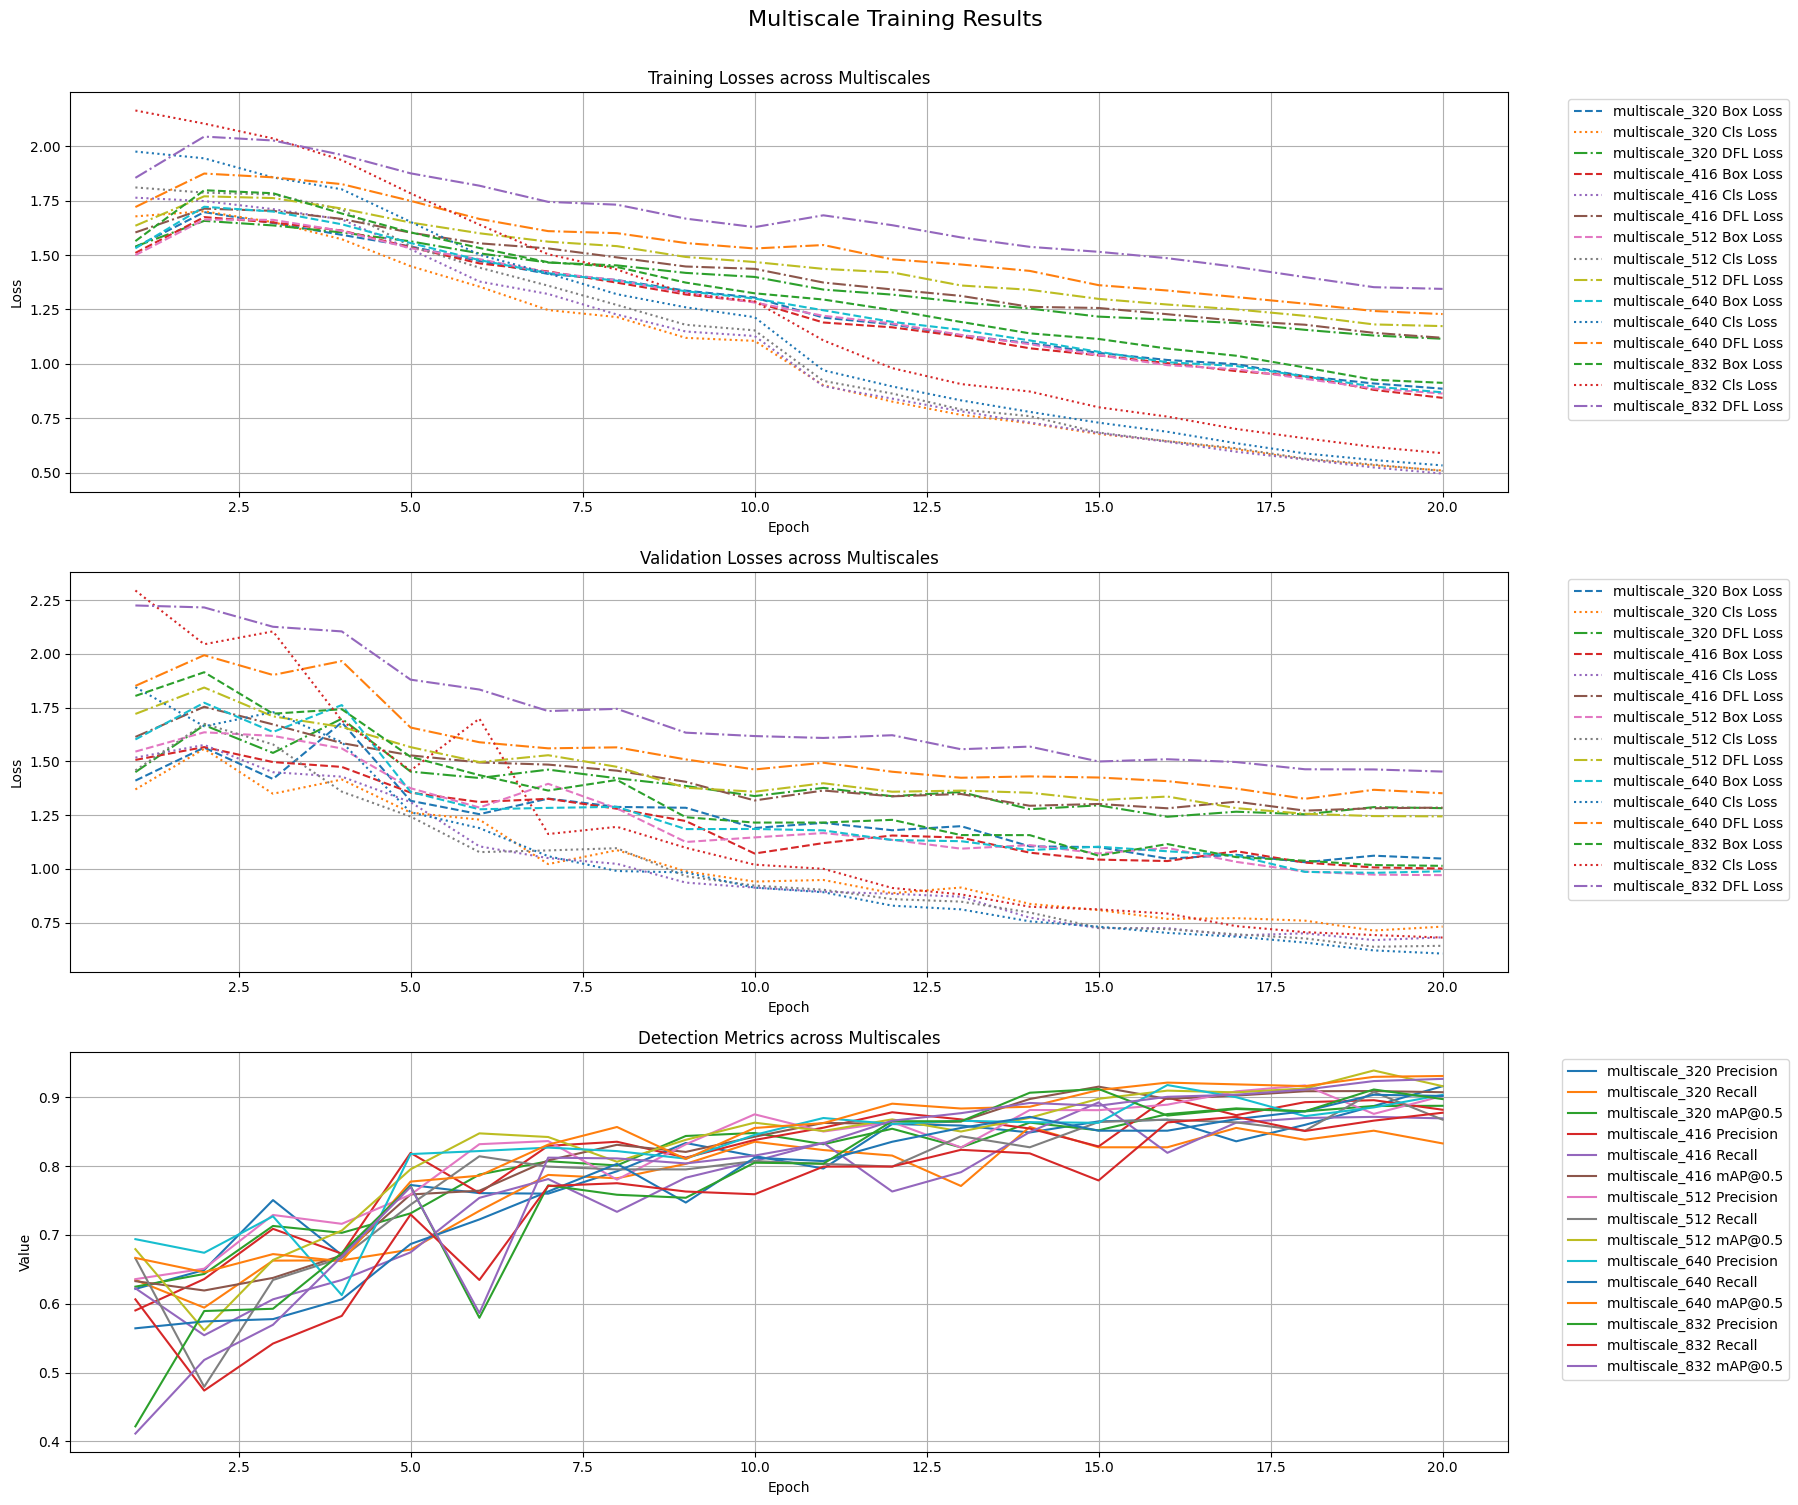

In [ ]:
# prompt: plot für den obigen trainingsdurchlauf für alle multiscales, und zwar in einer guten ansicht leserlich

import pandas as pd
import matplotlib.pyplot as plt
# Sammle alle multiscale CSV-Dateien
multiscale_runs = glob.glob('./runs/detect/multiscale_*/results.csv')

print(f"Gefundene Runs: {multiscale_runs}")

plt.figure(figsize=(18, 15))

# Plot Training Losses
plt.subplot(3, 1, 1)
for run_path in multiscale_runs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['train/box_loss'], label=f'{run_name} Box Loss', linestyle='--')
    plt.plot(df['epoch'], df['train/cls_loss'], label=f'{run_name} Cls Loss', linestyle=':')
    plt.plot(df['epoch'], df['train/dfl_loss'], label=f'{run_name} DFL Loss', linestyle='-.')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Losses across Multiscales')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1)); plt.grid(True)

# Plot Validation Losses
plt.subplot(3, 1, 2)
for run_path in multiscale_runs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['val/box_loss'], label=f'{run_name} Box Loss', linestyle='--')
    plt.plot(df['epoch'], df['val/cls_loss'], label=f'{run_name} Cls Loss', linestyle=':')
    plt.plot(df['epoch'], df['val/dfl_loss'], label=f'{run_name} DFL Loss', linestyle='-.')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Validation Losses across Multiscales')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1)); plt.grid(True)

# Plot Detection Metrics
plt.subplot(3, 1, 3)
for run_path in multiscale_runs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['metrics/precision(B)'], label=f'{run_name} Precision')
    plt.plot(df['epoch'], df['metrics/recall(B)'], label=f'{run_name} Recall')
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label=f'{run_name} mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics across Multiscales')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1)); plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97]) # Anpassung für die Legende
plt.suptitle('Multiscale Training Results', fontsize=16, y=1.0)
plt.show()


In [ ]:
# Analysiere die mAP50-Werte, um das beste und schlechteste Modell zu finden
best_map = -1
worst_map = float('inf')
best_model = None
worst_model = None

print("\nAnalyse der mAP50 Ergebnisse:")
for run_path in multiscale_runs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))

    # Finde den höchsten mAP50 Wert für diesen Run
    max_map = df['metrics/mAP50(B)'].max()

    print(f"{run_name}: Maximaler mAP50 = {max_map:.4f}")

    if max_map > best_map:
        best_map = max_map
        best_model = run_name

    if max_map < worst_map:
        worst_map = max_map
        worst_model = run_name

print(f"\nDas stärkste multiscale Modell (basierend auf maximalem mAP50): {best_model} mit mAP50 = {best_map:.4f}")
print(f"Das schwächste multiscale Modell (basierend auf maximalem mAP50): {worst_model} mit mAP50 = {worst_map:.4f}")



Analyse der mAP50 Ergebnisse:
multiscale_320: Maximaler mAP50 = 0.8875
multiscale_416: Maximaler mAP50 = 0.9154
multiscale_512: Maximaler mAP50 = 0.9389
multiscale_640: Maximaler mAP50 = 0.9309
multiscale_832: Maximaler mAP50 = 0.9267

Das stärkste multiscale Modell (basierend auf maximalem mAP50): multiscale_512 mit mAP50 = 0.9389
Das schwächste multiscale Modell (basierend auf maximalem mAP50): multiscale_320 mit mAP50 = 0.8875


3. Systematische Hyperparameteroptimierung

In [ ]:
# Systematische Hyperparameter-Suche
hyperparams = {
    'lr0': [0.001, 0.01, 0.1],
    'momentum': [0.8, 0.9, 0.95],
    'weight_decay': [0.0001, 0.0005, 0.001],
    'warmup_epochs': [1, 3, 5],
    'box': [7.5, 10.0, 12.5],
    'cls': [0.5, 1.0, 1.5],
    'dfl': [1.0, 1.5, 2.0]
}

best_score = 0
best_params = {}

for lr in hyperparams['lr0']:
    for momentum in hyperparams['momentum']:
        for weight_decay in hyperparams['weight_decay']:
            model = YOLO('yolov8s.pt')
            results = model.train(
                data='../data_small/dog_dataset.yaml',
                epochs=30,
                lr0=lr,
                momentum=momentum,
                weight_decay=weight_decay,
                name=f'hp_lr{lr}_m{momentum}_wd{weight_decay}',
                exist_ok=True
            )

            # Beste mAP50 auswerten
            if results.results_dict['metrics/mAP50(B)'] > best_score:
                best_score = results.results_dict['metrics/mAP50(B)']
                best_params = {'lr0': lr, 'momentum': momentum, 'weight_decay': weight_decay}

print(f"Best params: {best_params}, Score: {best_score}")

Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.8, mosaic=1.0, multi_scale=False, name=hp_lr0.001_m0.8_wd0.0001, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, p

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 7.6±14.9 ms, read: 61.9±34.7 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.001_m0.8_wd0.0001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.8' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.001_m0.8_wd0.0001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.72G      1.385      1.828      1.583          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        231        249       0.51      0.498      0.498      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.67G      1.556      1.623      1.708          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.01it/s]

                   all        231        249      0.663      0.578      0.594      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.68G      1.572      1.582      1.698          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.83it/s]


                   all        231        249      0.718      0.578      0.624      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.68G      1.543      1.531       1.68          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]

                   all        231        249      0.643      0.558      0.574      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.68G      1.465      1.441      1.614          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]

                   all        231        249      0.804      0.715      0.831      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.72G      1.406       1.31       1.56          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.84it/s]


                   all        231        249      0.733      0.731      0.761      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.72G      1.324      1.185      1.497          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]


                   all        231        249      0.901      0.815      0.903      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.72G       1.31      1.156      1.496          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]

                   all        231        249      0.843      0.799      0.875      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.72G      1.255       1.07      1.441          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]


                   all        231        249      0.863      0.831      0.899      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.72G      1.244      1.049      1.445          7        640: 100%|██████████| 154/154 [00:17<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.84it/s]

                   all        231        249        0.9      0.747      0.862      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.72G      1.188     0.9713      1.399          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]

                   all        231        249       0.85      0.835       0.89      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.72G      1.172     0.9499      1.409          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]

                   all        231        249      0.876      0.853      0.917      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.72G      1.156     0.9457      1.383          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.36it/s]

                   all        231        249      0.914      0.791      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.72G      1.126     0.8778      1.361          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]

                   all        231        249      0.887      0.867      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.72G      1.114      0.855      1.346          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        231        249      0.871      0.843      0.929      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.76G      1.063     0.8113      1.315          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.17it/s]

                   all        231        249      0.886      0.876      0.943      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.79G      1.016     0.7699      1.281          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.49it/s]

                   all        231        249      0.924       0.88      0.944      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.79G      1.014     0.7475      1.277          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]

                   all        231        249      0.913       0.88      0.949      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.79G     0.9865     0.7452      1.266          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]

                   all        231        249      0.945      0.893       0.97       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.79G     0.9556     0.7039      1.249          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]

                   all        231        249      0.953      0.903      0.967      0.693


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.79G     0.8781     0.5682      1.212          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]

                   all        231        249      0.963      0.892      0.968      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.79G     0.8277     0.5077      1.166          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]


                   all        231        249      0.966      0.904      0.973      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.79G     0.8175     0.4882      1.159          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]

                   all        231        249      0.958      0.904      0.974       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.79G     0.7609     0.4638      1.125          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.29it/s]

                   all        231        249      0.927      0.912      0.951      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.79G     0.7546       0.45      1.127          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]

                   all        231        249      0.931      0.924      0.963      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.79G     0.7133     0.4169      1.093          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]

                   all        231        249      0.935      0.928       0.97      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.79G     0.6925     0.4047      1.079          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]

                   all        231        249      0.975       0.92      0.977      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.79G     0.6478     0.3778      1.048          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.71it/s]

                   all        231        249      0.929      0.949      0.979      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.79G     0.6298     0.3594       1.04          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.33it/s]

                   all        231        249      0.975       0.92      0.982       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.79G     0.6071     0.3488      1.025          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.86it/s]

                   all        231        249      0.971       0.93      0.984      0.762



30 epochs completed in 0.158 hours.
Optimizer stripped from runs/detect/hp_lr0.001_m0.8_wd0.0001/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.001_m0.8_wd0.0001/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.001_m0.8_wd0.0001/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


                   all        231        249      0.971      0.929      0.984      0.762
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/hp_lr0.001_m0.8_wd0.0001
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 10.3±20.5 ms, read: 41.0±31.1 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.001_m0.8_wd0.0005/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.8' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.001_m0.8_wd0.0005
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       3.7G      1.368      1.819      1.582          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.70it/s]

                   all        231        249      0.665      0.605      0.635       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.65G      1.579      1.639       1.72          4        640: 100%|██████████| 154/154 [00:17<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.57it/s]

                   all        231        249      0.545       0.47      0.492      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.68G      1.578      1.613      1.704          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.14it/s]

                   all        231        249      0.585      0.438      0.479      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.68G      1.537      1.546      1.676          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.70it/s]


                   all        231        249      0.705      0.606       0.68      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.68G       1.47      1.426      1.613          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.12it/s]

                   all        231        249      0.813      0.715      0.774      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.68G      1.407      1.304      1.568          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.93it/s]

                   all        231        249      0.808      0.695      0.809      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.71G      1.341      1.198      1.503          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]

                   all        231        249      0.863      0.812      0.863      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.71G      1.327      1.161      1.499          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]

                   all        231        249       0.82      0.804      0.874      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.71G      1.261      1.088      1.451          6        640: 100%|██████████| 154/154 [00:15<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]

                   all        231        249      0.864      0.817      0.872      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.75G      1.251      1.053      1.449          7        640: 100%|██████████| 154/154 [00:17<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.16it/s]

                   all        231        249      0.874      0.807      0.898      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.79G      1.193     0.9764      1.402          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.59it/s]

                   all        231        249      0.892      0.855      0.912      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.79G      1.173     0.9788      1.399          2        640: 100%|██████████| 154/154 [00:18<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.74it/s]

                   all        231        249      0.903      0.835      0.922      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.79G      1.152     0.9252      1.388          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.43it/s]

                   all        231        249      0.874      0.834       0.92      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.79G      1.118     0.8784      1.361          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]

                   all        231        249      0.947      0.855      0.948      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.79G      1.108     0.8511      1.352          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.91it/s]

                   all        231        249      0.892      0.831      0.923      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.79G      1.083     0.8172      1.334          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]

                   all        231        249      0.903      0.864      0.931      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.79G      1.032     0.7801       1.29          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.08it/s]

                   all        231        249      0.901      0.875      0.938      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.79G      1.021     0.7575      1.282          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.40it/s]

                   all        231        249      0.871      0.924      0.952      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.79G      1.001       0.75       1.27          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]


                   all        231        249      0.949      0.905      0.965      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.79G     0.9601     0.7167      1.248          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.35it/s]

                   all        231        249       0.93      0.912      0.969      0.712


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.79G     0.8653     0.5734       1.21          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.54it/s]

                   all        231        249      0.934      0.896       0.97      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.79G     0.8242     0.5078      1.166          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]

                   all        231        249      0.957       0.89      0.971      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.79G      0.816     0.4979      1.162          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.69it/s]

                   all        231        249      0.924      0.934      0.972      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.79G     0.7635     0.4618       1.13          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]


                   all        231        249      0.958      0.907      0.974      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.79G      0.743     0.4416      1.117          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]

                   all        231        249      0.926       0.92      0.972      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.79G     0.7183     0.4191      1.098          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]


                   all        231        249      0.945      0.944      0.978      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.79G     0.6851     0.4036      1.077          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.37it/s]


                   all        231        249      0.963      0.924      0.973      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.79G     0.6465     0.3771      1.051          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        231        249      0.968       0.94      0.988       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.79G     0.6364     0.3625      1.045          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.43it/s]

                   all        231        249      0.959      0.949      0.983       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.79G     0.5982     0.3432      1.019          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.04it/s]

                   all        231        249      0.965      0.936      0.983      0.762



30 epochs completed in 0.158 hours.
Optimizer stripped from runs/detect/hp_lr0.001_m0.8_wd0.0005/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.001_m0.8_wd0.0005/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.001_m0.8_wd0.0005/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]


                   all        231        249      0.967      0.938      0.983      0.761
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/hp_lr0.001_m0.8_wd0.0005
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.2±0.6 ms, read: 24.1±16.2 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.001_m0.8_wd0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.8' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.001_m0.8_wd0.001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.01G      1.381      1.804      1.582          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.85it/s]

                   all        231        249       0.42      0.446      0.397      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.96G      1.571      1.629      1.718          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.09it/s]


                   all        231        249      0.677      0.605      0.656      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.96G      1.578      1.618      1.709          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.76it/s]

                   all        231        249       0.69      0.578      0.662      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.96G      1.556      1.543      1.681          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.75it/s]

                   all        231        249      0.762      0.627      0.704      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.96G      1.457      1.419      1.587          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]


                   all        231        249      0.875      0.676      0.829      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.96G      1.408      1.298      1.555          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.50it/s]

                   all        231        249      0.701      0.703      0.738      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.96G      1.357      1.232      1.515          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.10it/s]

                   all        231        249      0.839      0.772      0.869      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.96G      1.308      1.167      1.496          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.51it/s]

                   all        231        249      0.852      0.807      0.875      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.96G      1.251      1.089      1.435          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.50it/s]


                   all        231        249      0.836      0.842      0.905      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.96G      1.234      1.046      1.426          7        640: 100%|██████████| 154/154 [00:17<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.70it/s]


                   all        231        249      0.909      0.819      0.906      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.96G      1.176      0.953      1.391          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.29it/s]

                   all        231        249      0.913      0.831      0.934      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.96G      1.166     0.9525      1.394          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.56it/s]


                   all        231        249      0.957      0.831      0.935      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.96G      1.146     0.9206      1.373          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.27it/s]

                   all        231        249      0.877      0.859      0.939      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.96G      1.119     0.8923      1.355          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.30it/s]

                   all        231        249      0.917       0.89      0.954      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.96G      1.101     0.8401      1.338          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.30it/s]


                   all        231        249       0.93      0.807      0.935      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.96G      1.069     0.8172      1.319          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.84it/s]

                   all        231        249      0.935      0.892      0.963      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.96G       1.02     0.7643      1.282          5        640: 100%|██████████| 154/154 [00:18<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]


                   all        231        249      0.903      0.908      0.954      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.96G      1.015     0.7614      1.279          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.93it/s]

                   all        231        249      0.894      0.912      0.964      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.96G     0.9896     0.7605       1.26          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]

                   all        231        249      0.933      0.871      0.949       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.98G     0.9587      0.709      1.248          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.92it/s]

                   all        231        249      0.901      0.924      0.968      0.708


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.02G     0.8934     0.5778       1.22          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.83it/s]


                   all        231        249      0.912       0.87      0.959      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.02G     0.8343     0.5211      1.174          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.14it/s]

                   all        231        249      0.956      0.879       0.96      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.02G     0.8071     0.4925      1.154          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]

                   all        231        249      0.938      0.904      0.971       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.02G     0.7801     0.4736       1.14          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]

                   all        231        249      0.948      0.908      0.962      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.02G      0.746     0.4466      1.118          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]

                   all        231        249      0.942      0.913      0.969      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.02G     0.7266      0.431      1.103          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        231        249      0.912      0.918      0.966      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.02G     0.6932     0.4072      1.082          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]

                   all        231        249      0.954      0.907      0.976      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.02G     0.6508     0.3742      1.053          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.25it/s]

                   all        231        249      0.961      0.896      0.978      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.02G     0.6388     0.3631       1.05          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.86it/s]

                   all        231        249      0.945      0.912      0.976      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.06G     0.6093     0.3555      1.022          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]


                   all        231        249      0.954       0.92      0.978      0.749

30 epochs completed in 0.159 hours.
Optimizer stripped from runs/detect/hp_lr0.001_m0.8_wd0.001/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.001_m0.8_wd0.001/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.001_m0.8_wd0.001/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]


                   all        231        249      0.954       0.92      0.978      0.749
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/hp_lr0.001_m0.8_wd0.001
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 5.4±8.9 ms, read: 59.8±50.9 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.001_m0.9_wd0.0001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.001_m0.9_wd0.0001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.86G      1.385      1.828      1.583          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]


                   all        231        249       0.51      0.498      0.498      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.81G      1.556      1.623      1.708          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.82it/s]


                   all        231        249      0.663      0.578      0.594      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.81G      1.572      1.582      1.698          4        640: 100%|██████████| 154/154 [00:18<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.79it/s]

                   all        231        249      0.718      0.578      0.624      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.81G      1.543      1.531       1.68          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.66it/s]

                   all        231        249      0.643      0.558      0.574      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.81G      1.465      1.441      1.614          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.64it/s]

                   all        231        249      0.804      0.715      0.831      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.81G      1.406       1.31       1.56          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.09it/s]

                   all        231        249      0.733      0.731      0.761      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.81G      1.324      1.185      1.497          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.67it/s]


                   all        231        249      0.901      0.815      0.903      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.81G       1.31      1.156      1.496          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]


                   all        231        249      0.843      0.799      0.875      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.81G      1.255       1.07      1.441          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.62it/s]

                   all        231        249      0.863      0.831      0.899      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.81G      1.244      1.049      1.445          7        640: 100%|██████████| 154/154 [00:17<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.28it/s]

                   all        231        249        0.9      0.747      0.862      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.81G      1.188     0.9713      1.399          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.29it/s]

                   all        231        249       0.85      0.835       0.89      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.81G      1.172     0.9499      1.409          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.14it/s]

                   all        231        249      0.876      0.853      0.917      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.81G      1.156     0.9457      1.383          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]

                   all        231        249      0.914      0.791      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.81G      1.126     0.8778      1.361          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.15it/s]

                   all        231        249      0.887      0.867      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.81G      1.114      0.855      1.346          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]

                   all        231        249      0.871      0.843      0.929      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.81G      1.063     0.8113      1.315          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.20it/s]

                   all        231        249      0.886      0.876      0.943      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.81G      1.016     0.7699      1.281          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]


                   all        231        249      0.924       0.88      0.944      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.81G      1.014     0.7475      1.277          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.43it/s]

                   all        231        249      0.913       0.88      0.949      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.81G     0.9865     0.7452      1.266          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]

                   all        231        249      0.945      0.893       0.97       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.81G     0.9556     0.7039      1.249          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]


                   all        231        249      0.953      0.903      0.967      0.693
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.84G     0.8781     0.5682      1.212          3        640: 100%|██████████| 154/154 [00:19<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.51it/s]

                   all        231        249      0.963      0.892      0.968      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.84G     0.8277     0.5077      1.166          2        640: 100%|██████████| 154/154 [00:18<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]

                   all        231        249      0.966      0.904      0.973      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.88G     0.8175     0.4882      1.159          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        231        249      0.958      0.904      0.974       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.88G     0.7609     0.4638      1.125          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.37it/s]

                   all        231        249      0.927      0.912      0.951      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.88G     0.7546       0.45      1.127          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.54it/s]

                   all        231        249      0.931      0.924      0.963      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.88G     0.7133     0.4169      1.093          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.81it/s]

                   all        231        249      0.935      0.928       0.97      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.88G     0.6925     0.4047      1.079          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]

                   all        231        249      0.975       0.92      0.977      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.88G     0.6478     0.3778      1.048          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.39it/s]

                   all        231        249      0.929      0.949      0.979      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.88G     0.6298     0.3594       1.04          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.04it/s]


                   all        231        249      0.975       0.92      0.982       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.88G     0.6071     0.3488      1.025          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.83it/s]

                   all        231        249      0.971       0.93      0.984      0.762



30 epochs completed in 0.159 hours.
Optimizer stripped from runs/detect/hp_lr0.001_m0.9_wd0.0001/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.001_m0.9_wd0.0001/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.001_m0.9_wd0.0001/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]


                   all        231        249      0.971      0.929      0.984      0.762
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/hp_lr0.001_m0.9_wd0.0001
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.1±0.9 ms, read: 54.6±34.0 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.001_m0.9_wd0.0005/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.001_m0.9_wd0.0005
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.85G      1.368      1.819      1.582          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.91it/s]

                   all        231        249      0.665      0.605      0.635       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       4.8G      1.579      1.639       1.72          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.70it/s]

                   all        231        249      0.545       0.47      0.492      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       4.8G      1.578      1.613      1.704          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]

                   all        231        249      0.585      0.438      0.479      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       4.8G      1.537      1.546      1.676          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.98it/s]

                   all        231        249      0.705      0.606       0.68      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       4.8G       1.47      1.426      1.613          4        640: 100%|██████████| 154/154 [00:18<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]

                   all        231        249      0.813      0.715      0.774      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       4.8G      1.407      1.304      1.568          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.82it/s]

                   all        231        249      0.808      0.695      0.809      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       4.8G      1.341      1.198      1.503          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.20it/s]

                   all        231        249      0.863      0.812      0.863      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       4.8G      1.327      1.161      1.499          5        640: 100%|██████████| 154/154 [00:18<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.55it/s]

                   all        231        249       0.82      0.804      0.874      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       4.8G      1.261      1.088      1.451          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.17it/s]


                   all        231        249      0.864      0.817      0.872      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.81G      1.251      1.053      1.449          7        640: 100%|██████████| 154/154 [00:17<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.35it/s]


                   all        231        249      0.874      0.807      0.898      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.81G      1.193     0.9764      1.402          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.95it/s]

                   all        231        249      0.892      0.855      0.912      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.81G      1.173     0.9788      1.399          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]

                   all        231        249      0.903      0.835      0.922      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.81G      1.152     0.9252      1.388          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.43it/s]

                   all        231        249      0.874      0.834       0.92      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.81G      1.118     0.8784      1.361          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.58it/s]

                   all        231        249      0.947      0.855      0.948      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.81G      1.108     0.8511      1.352          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.11it/s]

                   all        231        249      0.892      0.831      0.923      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.81G      1.083     0.8172      1.334          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.91it/s]

                   all        231        249      0.903      0.864      0.931      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.85G      1.032     0.7801       1.29          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.16it/s]

                   all        231        249      0.901      0.875      0.938      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.85G      1.021     0.7575      1.282          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.50it/s]

                   all        231        249      0.871      0.924      0.952      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.85G      1.001       0.75       1.27          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.09it/s]

                   all        231        249      0.949      0.905      0.965      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.85G     0.9601     0.7167      1.248          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]

                   all        231        249       0.93      0.912      0.969      0.712


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.85G     0.8653     0.5734       1.21          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.27it/s]

                   all        231        249      0.934      0.896       0.97      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.88G     0.8242     0.5078      1.166          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]

                   all        231        249      0.957       0.89      0.971      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.88G      0.816     0.4979      1.162          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.54it/s]

                   all        231        249      0.924      0.934      0.972      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.88G     0.7635     0.4618       1.13          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]

                   all        231        249      0.958      0.907      0.974      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.88G      0.743     0.4416      1.117          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.06it/s]

                   all        231        249      0.926       0.92      0.972      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.88G     0.7183     0.4191      1.098          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.64it/s]

                   all        231        249      0.945      0.944      0.978      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.88G     0.6851     0.4036      1.077          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]

                   all        231        249      0.963      0.924      0.973      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.88G     0.6465     0.3771      1.051          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]

                   all        231        249      0.968       0.94      0.988       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.88G     0.6364     0.3625      1.045          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        231        249      0.959      0.949      0.983       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.88G     0.5982     0.3432      1.019          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]

                   all        231        249      0.965      0.936      0.983      0.762



30 epochs completed in 0.158 hours.
Optimizer stripped from runs/detect/hp_lr0.001_m0.9_wd0.0005/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.001_m0.9_wd0.0005/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.001_m0.9_wd0.0005/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]


                   all        231        249      0.967      0.938      0.983      0.761
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/hp_lr0.001_m0.9_wd0.0005
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.1±1.1 ms, read: 61.5±52.1 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.001_m0.9_wd0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.001_m0.9_wd0.001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.98G      1.381      1.804      1.582          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.94it/s]


                   all        231        249       0.42      0.446      0.397      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.94G      1.571      1.629      1.718          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.28it/s]

                   all        231        249      0.677      0.605      0.656      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.94G      1.578      1.618      1.709          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.78it/s]

                   all        231        249       0.69      0.578      0.662      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.94G      1.556      1.543      1.681          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.86it/s]

                   all        231        249      0.762      0.627      0.704      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.94G      1.457      1.419      1.587          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.09it/s]

                   all        231        249      0.875      0.676      0.829      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.95G      1.408      1.298      1.555          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.24it/s]


                   all        231        249      0.701      0.703      0.738      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.98G      1.357      1.232      1.515          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]


                   all        231        249      0.839      0.772      0.869      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.02G      1.308      1.167      1.496          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        231        249      0.852      0.807      0.875      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.02G      1.251      1.089      1.435          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.16it/s]

                   all        231        249      0.836      0.842      0.905      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.05G      1.234      1.046      1.426          7        640: 100%|██████████| 154/154 [00:17<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]

                   all        231        249      0.909      0.819      0.906      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.09G      1.176      0.953      1.391          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.85it/s]

                   all        231        249      0.913      0.831      0.934      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.09G      1.166     0.9525      1.394          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]

                   all        231        249      0.957      0.831      0.935      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.09G      1.146     0.9206      1.373          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.12it/s]

                   all        231        249      0.877      0.859      0.939      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.09G      1.119     0.8923      1.355          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]

                   all        231        249      0.917       0.89      0.954      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.09G      1.101     0.8401      1.338          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.06it/s]

                   all        231        249       0.93      0.807      0.935      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.09G      1.069     0.8172      1.319          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        231        249      0.935      0.892      0.963      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.09G       1.02     0.7643      1.282          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]

                   all        231        249      0.903      0.908      0.954      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.09G      1.015     0.7614      1.279          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.20it/s]

                   all        231        249      0.894      0.912      0.964      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.09G     0.9896     0.7605       1.26          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.19it/s]

                   all        231        249      0.933      0.871      0.949       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.09G     0.9587      0.709      1.248          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        231        249      0.901      0.924      0.968      0.708


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.09G     0.8934     0.5778       1.22          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.01it/s]

                   all        231        249      0.912       0.87      0.959      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.09G     0.8343     0.5211      1.174          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        231        249      0.956      0.879       0.96      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.09G     0.8071     0.4925      1.154          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.95it/s]

                   all        231        249      0.938      0.904      0.971       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.09G     0.7801     0.4736       1.14          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]

                   all        231        249      0.948      0.908      0.962      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.09G      0.746     0.4466      1.118          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.27it/s]

                   all        231        249      0.942      0.913      0.969      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.09G     0.7266      0.431      1.103          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.69it/s]

                   all        231        249      0.912      0.918      0.966      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.09G     0.6932     0.4072      1.082          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        231        249      0.954      0.907      0.976      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.09G     0.6508     0.3742      1.053          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]

                   all        231        249      0.961      0.896      0.978      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.09G     0.6388     0.3631       1.05          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]

                   all        231        249      0.945      0.912      0.976      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.09G     0.6093     0.3555      1.022          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.61it/s]

                   all        231        249      0.954       0.92      0.978      0.749



30 epochs completed in 0.159 hours.
Optimizer stripped from runs/detect/hp_lr0.001_m0.9_wd0.001/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.001_m0.9_wd0.001/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.001_m0.9_wd0.001/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]


                   all        231        249      0.954       0.92      0.978      0.749
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/hp_lr0.001_m0.9_wd0.001
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.2±1.2 ms, read: 63.0±42.8 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.001_m0.95_wd0.0001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.95' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.001_m0.95_wd0.0001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.97G      1.385      1.828      1.583          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]

                   all        231        249       0.51      0.498      0.498      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.93G      1.556      1.623      1.708          4        640: 100%|██████████| 154/154 [00:18<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.82it/s]

                   all        231        249      0.663      0.578      0.594      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.93G      1.572      1.582      1.698          4        640: 100%|██████████| 154/154 [00:18<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.09it/s]

                   all        231        249      0.718      0.578      0.624      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.93G      1.543      1.531       1.68          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.94it/s]

                   all        231        249      0.643      0.558      0.574      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.93G      1.465      1.441      1.614          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.75it/s]

                   all        231        249      0.804      0.715      0.831      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.93G      1.406       1.31       1.56          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.88it/s]

                   all        231        249      0.733      0.731      0.761      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.93G      1.324      1.185      1.497          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]

                   all        231        249      0.901      0.815      0.903      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.93G       1.31      1.156      1.496          5        640: 100%|██████████| 154/154 [00:18<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.61it/s]


                   all        231        249      0.843      0.799      0.875      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.93G      1.255       1.07      1.441          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]


                   all        231        249      0.863      0.831      0.899      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.93G      1.244      1.049      1.445          7        640: 100%|██████████| 154/154 [00:18<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.92it/s]

                   all        231        249        0.9      0.747      0.862      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.93G      1.188     0.9713      1.399          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]

                   all        231        249       0.85      0.835       0.89      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.93G      1.172     0.9499      1.409          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.85it/s]


                   all        231        249      0.876      0.853      0.917      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.93G      1.156     0.9457      1.383          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]

                   all        231        249      0.914      0.791      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.93G      1.126     0.8778      1.361          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.67it/s]

                   all        231        249      0.887      0.867      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.95G      1.114      0.855      1.346          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]

                   all        231        249      0.871      0.843      0.929      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.95G      1.063     0.8113      1.315          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.87it/s]


                   all        231        249      0.886      0.876      0.943      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.95G      1.016     0.7699      1.281          5        640: 100%|██████████| 154/154 [00:18<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.37it/s]

                   all        231        249      0.924       0.88      0.944      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.98G      1.014     0.7475      1.277          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.85it/s]

                   all        231        249      0.913       0.88      0.949      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.02G     0.9865     0.7452      1.266          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]

                   all        231        249      0.945      0.893       0.97       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.02G     0.9556     0.7039      1.249          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.35it/s]

                   all        231        249      0.953      0.903      0.967      0.693


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.06G     0.8781     0.5682      1.212          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]

                   all        231        249      0.963      0.892      0.968      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.06G     0.8277     0.5077      1.166          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.16it/s]

                   all        231        249      0.966      0.904      0.973      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.06G     0.8175     0.4882      1.159          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        231        249      0.958      0.904      0.974       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.06G     0.7609     0.4638      1.125          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]

                   all        231        249      0.927      0.912      0.951      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.06G     0.7546       0.45      1.127          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]


                   all        231        249      0.931      0.924      0.963      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.06G     0.7133     0.4169      1.093          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.54it/s]


                   all        231        249      0.935      0.928       0.97      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.06G     0.6925     0.4047      1.079          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.40it/s]

                   all        231        249      0.975       0.92      0.977      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.06G     0.6478     0.3778      1.048          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]

                   all        231        249      0.929      0.949      0.979      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.06G     0.6298     0.3594       1.04          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.36it/s]

                   all        231        249      0.975       0.92      0.982       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.09G     0.6071     0.3488      1.025          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]

                   all        231        249      0.971       0.93      0.984      0.762



30 epochs completed in 0.160 hours.
Optimizer stripped from runs/detect/hp_lr0.001_m0.95_wd0.0001/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.001_m0.95_wd0.0001/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.001_m0.95_wd0.0001/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


                   all        231        249      0.971      0.929      0.984      0.762
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/hp_lr0.001_m0.95_wd0.0001
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.2±3.4 ms, read: 79.1±57.7 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.001_m0.95_wd0.0005/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.95' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.001_m0.95_wd0.0005
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.84G      1.368      1.819      1.582          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]


                   all        231        249      0.665      0.605      0.635       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.79G      1.579      1.639       1.72          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.66it/s]

                   all        231        249      0.545       0.47      0.492      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.79G      1.578      1.613      1.704          4        640: 100%|██████████| 154/154 [00:17<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.91it/s]


                   all        231        249      0.585      0.438      0.479      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.79G      1.537      1.546      1.676          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.98it/s]

                   all        231        249      0.705      0.606       0.68      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.79G       1.47      1.426      1.613          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.99it/s]


                   all        231        249      0.813      0.715      0.774      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.79G      1.407      1.304      1.568          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.98it/s]

                   all        231        249      0.808      0.695      0.809      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       4.8G      1.341      1.198      1.503          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.99it/s]

                   all        231        249      0.863      0.812      0.863      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.84G      1.327      1.161      1.499          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.03it/s]

                   all        231        249       0.82      0.804      0.874      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.88G      1.261      1.088      1.451          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.36it/s]

                   all        231        249      0.864      0.817      0.872      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.88G      1.251      1.053      1.449          7        640: 100%|██████████| 154/154 [00:17<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.94it/s]

                   all        231        249      0.874      0.807      0.898      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.88G      1.193     0.9764      1.402          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.36it/s]

                   all        231        249      0.892      0.855      0.912      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.88G      1.173     0.9788      1.399          2        640: 100%|██████████| 154/154 [00:18<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.62it/s]

                   all        231        249      0.903      0.835      0.922      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.88G      1.152     0.9252      1.388          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]

                   all        231        249      0.874      0.834       0.92      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.88G      1.118     0.8784      1.361          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.46it/s]

                   all        231        249      0.947      0.855      0.948      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.88G      1.108     0.8511      1.352          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]

                   all        231        249      0.892      0.831      0.923      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.88G      1.083     0.8172      1.334          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]

                   all        231        249      0.903      0.864      0.931      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.88G      1.032     0.7801       1.29          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]

                   all        231        249      0.901      0.875      0.938      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.88G      1.021     0.7575      1.282          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]

                   all        231        249      0.871      0.924      0.952      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.88G      1.001       0.75       1.27          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.20it/s]

                   all        231        249      0.949      0.905      0.965      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.88G     0.9601     0.7167      1.248          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.04it/s]

                   all        231        249       0.93      0.912      0.969      0.712


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.88G     0.8653     0.5734       1.21          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]


                   all        231        249      0.934      0.896       0.97      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.88G     0.8242     0.5078      1.166          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]

                   all        231        249      0.957       0.89      0.971      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.88G      0.816     0.4979      1.162          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]

                   all        231        249      0.924      0.934      0.972      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.88G     0.7635     0.4618       1.13          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]


                   all        231        249      0.958      0.907      0.974      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.88G      0.743     0.4416      1.117          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]

                   all        231        249      0.926       0.92      0.972      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.88G     0.7183     0.4191      1.098          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]


                   all        231        249      0.945      0.944      0.978      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.88G     0.6851     0.4036      1.077          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.41it/s]

                   all        231        249      0.963      0.924      0.973      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.88G     0.6465     0.3771      1.051          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.43it/s]

                   all        231        249      0.968       0.94      0.988       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.88G     0.6364     0.3625      1.045          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]

                   all        231        249      0.959      0.949      0.983       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.88G     0.5982     0.3432      1.019          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]

                   all        231        249      0.965      0.936      0.983      0.762



30 epochs completed in 0.159 hours.
Optimizer stripped from runs/detect/hp_lr0.001_m0.95_wd0.0005/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.001_m0.95_wd0.0005/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.001_m0.95_wd0.0005/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.14it/s]


                   all        231        249      0.967      0.938      0.983      0.761
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/hp_lr0.001_m0.95_wd0.0005
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 14.4±29.0 ms, read: 23.4±26.9 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.001_m0.95_wd0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.95' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.001_m0.95_wd0.001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.99G      1.381      1.804      1.582          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.16it/s]


                   all        231        249       0.42      0.446      0.397      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.94G      1.571      1.629      1.718          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.20it/s]

                   all        231        249      0.677      0.605      0.656      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.94G      1.578      1.618      1.709          4        640: 100%|██████████| 154/154 [00:18<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.48it/s]

                   all        231        249       0.69      0.578      0.662      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.95G      1.556      1.543      1.681          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]


                   all        231        249      0.762      0.627      0.704      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.95G      1.457      1.419      1.587          4        640: 100%|██████████| 154/154 [00:18<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]


                   all        231        249      0.875      0.676      0.829      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.95G      1.408      1.298      1.555          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.11it/s]

                   all        231        249      0.701      0.703      0.738      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.95G      1.357      1.232      1.515          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]


                   all        231        249      0.839      0.772      0.869      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.99G      1.308      1.167      1.496          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.33it/s]

                   all        231        249      0.852      0.807      0.875      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.99G      1.251      1.089      1.435          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]

                   all        231        249      0.836      0.842      0.905      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.99G      1.234      1.046      1.426          7        640: 100%|██████████| 154/154 [00:17<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]


                   all        231        249      0.909      0.819      0.906      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.99G      1.176      0.953      1.391          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]

                   all        231        249      0.913      0.831      0.934      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.99G      1.166     0.9525      1.394          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.45it/s]

                   all        231        249      0.957      0.831      0.935      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.02G      1.146     0.9206      1.373          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.80it/s]


                   all        231        249      0.877      0.859      0.939      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.02G      1.119     0.8923      1.355          5        640: 100%|██████████| 154/154 [00:18<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        231        249      0.917       0.89      0.954      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.02G      1.101     0.8401      1.338          4        640: 100%|██████████| 154/154 [00:18<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.64it/s]

                   all        231        249       0.93      0.807      0.935      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.02G      1.069     0.8172      1.319          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]

                   all        231        249      0.935      0.892      0.963      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.02G       1.02     0.7643      1.282          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]

                   all        231        249      0.903      0.908      0.954      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.02G      1.015     0.7614      1.279          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        231        249      0.894      0.912      0.964      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.02G     0.9896     0.7605       1.26          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.42it/s]

                   all        231        249      0.933      0.871      0.949       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.02G     0.9587      0.709      1.248          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]

                   all        231        249      0.901      0.924      0.968      0.708


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.02G     0.8934     0.5778       1.22          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]

                   all        231        249      0.912       0.87      0.959      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.02G     0.8343     0.5211      1.174          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]

                   all        231        249      0.956      0.879       0.96      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.02G     0.8071     0.4925      1.154          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.79it/s]

                   all        231        249      0.938      0.904      0.971       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.02G     0.7801     0.4736       1.14          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]

                   all        231        249      0.948      0.908      0.962      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.02G      0.746     0.4466      1.118          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.95it/s]

                   all        231        249      0.942      0.913      0.969      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.02G     0.7266      0.431      1.103          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]

                   all        231        249      0.912      0.918      0.966      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.02G     0.6932     0.4072      1.082          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.43it/s]


                   all        231        249      0.954      0.907      0.976      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.02G     0.6508     0.3742      1.053          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        231        249      0.961      0.896      0.978      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.02G     0.6388     0.3631       1.05          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]

                   all        231        249      0.945      0.912      0.976      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.02G     0.6093     0.3555      1.022          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.33it/s]

                   all        231        249      0.954       0.92      0.978      0.749



30 epochs completed in 0.161 hours.
Optimizer stripped from runs/detect/hp_lr0.001_m0.95_wd0.001/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.001_m0.95_wd0.001/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.001_m0.95_wd0.001/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]


                   all        231        249      0.954       0.92      0.978      0.749
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/hp_lr0.001_m0.95_wd0.001
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 7.2±11.2 ms, read: 27.5±24.2 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.01_m0.8_wd0.0001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.8' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.01_m0.8_wd0.0001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.84G      1.385      1.828      1.583          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.73it/s]

                   all        231        249       0.51      0.498      0.498      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.79G      1.556      1.623      1.708          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]


                   all        231        249      0.663      0.578      0.594      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.81G      1.572      1.582      1.698          4        640: 100%|██████████| 154/154 [00:18<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.89it/s]

                   all        231        249      0.718      0.578      0.624      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.81G      1.543      1.531       1.68          4        640: 100%|██████████| 154/154 [00:18<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.03it/s]


                   all        231        249      0.643      0.558      0.574      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.81G      1.465      1.441      1.614          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]

                   all        231        249      0.804      0.715      0.831      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.81G      1.406       1.31       1.56          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.97it/s]

                   all        231        249      0.733      0.731      0.761      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.81G      1.324      1.185      1.497          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.27it/s]

                   all        231        249      0.901      0.815      0.903      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.81G       1.31      1.156      1.496          5        640: 100%|██████████| 154/154 [00:18<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.95it/s]

                   all        231        249      0.843      0.799      0.875      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.81G      1.255       1.07      1.441          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.08it/s]


                   all        231        249      0.863      0.831      0.899      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.81G      1.244      1.049      1.445          7        640: 100%|██████████| 154/154 [00:18<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]


                   all        231        249        0.9      0.747      0.862      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.81G      1.188     0.9713      1.399          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]

                   all        231        249       0.85      0.835       0.89      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.81G      1.172     0.9499      1.409          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.15it/s]

                   all        231        249      0.876      0.853      0.917      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.81G      1.156     0.9457      1.383          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]

                   all        231        249      0.914      0.791      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.81G      1.126     0.8778      1.361          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.01it/s]

                   all        231        249      0.887      0.867      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.81G      1.114      0.855      1.346          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        231        249      0.871      0.843      0.929      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.81G      1.063     0.8113      1.315          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.69it/s]

                   all        231        249      0.886      0.876      0.943      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.81G      1.016     0.7699      1.281          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]

                   all        231        249      0.924       0.88      0.944      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.81G      1.014     0.7475      1.277          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.14it/s]

                   all        231        249      0.913       0.88      0.949      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.81G     0.9865     0.7452      1.266          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.15it/s]

                   all        231        249      0.945      0.893       0.97       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.81G     0.9556     0.7039      1.249          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]

                   all        231        249      0.953      0.903      0.967      0.693


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.81G     0.8781     0.5682      1.212          3        640: 100%|██████████| 154/154 [00:19<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]

                   all        231        249      0.963      0.892      0.968      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.81G     0.8277     0.5077      1.166          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.84it/s]

                   all        231        249      0.966      0.904      0.973      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.81G     0.8175     0.4882      1.159          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]

                   all        231        249      0.958      0.904      0.974       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.81G     0.7609     0.4638      1.125          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]

                   all        231        249      0.927      0.912      0.951      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.81G     0.7546       0.45      1.127          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]

                   all        231        249      0.931      0.924      0.963      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.81G     0.7133     0.4169      1.093          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.37it/s]

                   all        231        249      0.935      0.928       0.97      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.81G     0.6925     0.4047      1.079          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.28it/s]

                   all        231        249      0.975       0.92      0.977      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.81G     0.6478     0.3778      1.048          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.33it/s]

                   all        231        249      0.929      0.949      0.979      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.81G     0.6298     0.3594       1.04          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.17it/s]

                   all        231        249      0.975       0.92      0.982       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.81G     0.6071     0.3488      1.025          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]

                   all        231        249      0.971       0.93      0.984      0.762



30 epochs completed in 0.160 hours.
Optimizer stripped from runs/detect/hp_lr0.01_m0.8_wd0.0001/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.01_m0.8_wd0.0001/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.01_m0.8_wd0.0001/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]


                   all        231        249      0.971      0.929      0.984      0.762
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/hp_lr0.01_m0.8_wd0.0001
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 5.4±9.4 ms, read: 50.0±49.2 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.01_m0.8_wd0.0005/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.8' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.01_m0.8_wd0.0005
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.97G      1.368      1.819      1.582          6        640: 100%|██████████| 154/154 [00:18<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.06it/s]

                   all        231        249      0.665      0.605      0.635       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.93G      1.579      1.639       1.72          4        640: 100%|██████████| 154/154 [00:17<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.59it/s]

                   all        231        249      0.545       0.47      0.492      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.93G      1.578      1.613      1.704          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]

                   all        231        249      0.585      0.438      0.479      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.93G      1.537      1.546      1.676          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.19it/s]


                   all        231        249      0.705      0.606       0.68      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.93G       1.47      1.426      1.613          4        640: 100%|██████████| 154/154 [00:18<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]

                   all        231        249      0.813      0.715      0.774      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.95G      1.407      1.304      1.568          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.01it/s]

                   all        231        249      0.808      0.695      0.809      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.99G      1.341      1.198      1.503          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.30it/s]

                   all        231        249      0.863      0.812      0.863      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.99G      1.327      1.161      1.499          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]

                   all        231        249       0.82      0.804      0.874      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.99G      1.261      1.088      1.451          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.19it/s]


                   all        231        249      0.864      0.817      0.872      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.99G      1.251      1.053      1.449          7        640: 100%|██████████| 154/154 [00:17<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.09it/s]

                   all        231        249      0.874      0.807      0.898      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.99G      1.193     0.9764      1.402          5        640: 100%|██████████| 154/154 [00:18<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]

                   all        231        249      0.892      0.855      0.912      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.99G      1.173     0.9788      1.399          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.25it/s]

                   all        231        249      0.903      0.835      0.922      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.03G      1.152     0.9252      1.388          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.08it/s]

                   all        231        249      0.874      0.834       0.92      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.03G      1.118     0.8784      1.361          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]

                   all        231        249      0.947      0.855      0.948      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.03G      1.108     0.8511      1.352          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.81it/s]

                   all        231        249      0.892      0.831      0.923      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.03G      1.083     0.8172      1.334          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.45it/s]

                   all        231        249      0.903      0.864      0.931      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.03G      1.032     0.7801       1.29          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.87it/s]

                   all        231        249      0.901      0.875      0.938      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.03G      1.021     0.7575      1.282          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.59it/s]

                   all        231        249      0.871      0.924      0.952      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.03G      1.001       0.75       1.27          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.95it/s]

                   all        231        249      0.949      0.905      0.965      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.03G     0.9601     0.7167      1.248          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        231        249       0.93      0.912      0.969      0.712


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.03G     0.8653     0.5734       1.21          3        640: 100%|██████████| 154/154 [00:18<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.48it/s]

                   all        231        249      0.934      0.896       0.97      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.03G     0.8242     0.5078      1.166          2        640: 100%|██████████| 154/154 [00:17<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]

                   all        231        249      0.957       0.89      0.971      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.03G      0.816     0.4979      1.162          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.66it/s]

                   all        231        249      0.924      0.934      0.972      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.03G     0.7635     0.4618       1.13          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.25it/s]


                   all        231        249      0.958      0.907      0.974      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.03G      0.743     0.4416      1.117          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]

                   all        231        249      0.926       0.92      0.972      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.03G     0.7183     0.4191      1.098          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.17it/s]

                   all        231        249      0.945      0.944      0.978      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.03G     0.6851     0.4036      1.077          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]

                   all        231        249      0.963      0.924      0.973      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.03G     0.6465     0.3771      1.051          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.33it/s]

                   all        231        249      0.968       0.94      0.988       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.03G     0.6364     0.3625      1.045          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.05it/s]

                   all        231        249      0.959      0.949      0.983       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.03G     0.5982     0.3432      1.019          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]

                   all        231        249      0.965      0.936      0.983      0.762



30 epochs completed in 0.157 hours.
Optimizer stripped from runs/detect/hp_lr0.01_m0.8_wd0.0005/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.01_m0.8_wd0.0005/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.01_m0.8_wd0.0005/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


                   all        231        249      0.967      0.938      0.983      0.761
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/hp_lr0.01_m0.8_wd0.0005
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 3.6±6.5 ms, read: 55.2±50.3 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.01_m0.8_wd0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.8' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.01_m0.8_wd0.001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.84G      1.381      1.804      1.582          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]

                   all        231        249       0.42      0.446      0.397      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       4.8G      1.571      1.629      1.718          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.39it/s]


                   all        231        249      0.677      0.605      0.656      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       4.8G      1.578      1.618      1.709          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]


                   all        231        249       0.69      0.578      0.662      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       4.8G      1.556      1.543      1.681          4        640: 100%|██████████| 154/154 [00:15<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]


                   all        231        249      0.762      0.627      0.704      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       4.8G      1.457      1.419      1.587          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        231        249      0.875      0.676      0.829      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       4.8G      1.408      1.298      1.555          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        231        249      0.701      0.703      0.738      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       4.8G      1.357      1.232      1.515          6        640: 100%|██████████| 154/154 [00:15<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]

                   all        231        249      0.839      0.772      0.869      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.81G      1.308      1.167      1.496          5        640: 100%|██████████| 154/154 [00:17<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]

                   all        231        249      0.852      0.807      0.875      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.85G      1.251      1.089      1.435          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        231        249      0.836      0.842      0.905      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.88G      1.234      1.046      1.426          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.28it/s]

                   all        231        249      0.909      0.819      0.906      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.88G      1.176      0.953      1.391          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.59it/s]

                   all        231        249      0.913      0.831      0.934      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.92G      1.166     0.9525      1.394          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]


                   all        231        249      0.957      0.831      0.935      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.92G      1.146     0.9206      1.373          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]

                   all        231        249      0.877      0.859      0.939      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.92G      1.119     0.8923      1.355          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]

                   all        231        249      0.917       0.89      0.954      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.92G      1.101     0.8401      1.338          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]

                   all        231        249       0.93      0.807      0.935      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.92G      1.069     0.8172      1.319          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.06it/s]

                   all        231        249      0.935      0.892      0.963      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.92G       1.02     0.7643      1.282          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        231        249      0.903      0.908      0.954      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.92G      1.015     0.7614      1.279          7        640: 100%|██████████| 154/154 [00:15<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        231        249      0.894      0.912      0.964      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.96G     0.9896     0.7605       1.26          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]


                   all        231        249      0.933      0.871      0.949       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.99G     0.9587      0.709      1.248          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        231        249      0.901      0.924      0.968      0.708


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.99G     0.8934     0.5778       1.22          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]

                   all        231        249      0.912       0.87      0.959      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.99G     0.8343     0.5211      1.174          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        231        249      0.956      0.879       0.96      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.99G     0.8071     0.4925      1.154          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.80it/s]

                   all        231        249      0.938      0.904      0.971       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.99G     0.7801     0.4736       1.14          4        640: 100%|██████████| 154/154 [00:15<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]

                   all        231        249      0.948      0.908      0.962      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.99G      0.746     0.4466      1.118          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        231        249      0.942      0.913      0.969      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.99G     0.7266      0.431      1.103          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]

                   all        231        249      0.912      0.918      0.966      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.99G     0.6932     0.4072      1.082          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        231        249      0.954      0.907      0.976      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.99G     0.6508     0.3742      1.053          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]

                   all        231        249      0.961      0.896      0.978      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.99G     0.6388     0.3631       1.05          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.43it/s]

                   all        231        249      0.945      0.912      0.976      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.99G     0.6093     0.3555      1.022          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]

                   all        231        249      0.954       0.92      0.978      0.749



30 epochs completed in 0.151 hours.
Optimizer stripped from runs/detect/hp_lr0.01_m0.8_wd0.001/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.01_m0.8_wd0.001/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.01_m0.8_wd0.001/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


                   all        231        249      0.954       0.92      0.978      0.749
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/hp_lr0.01_m0.8_wd0.001
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.8±0.3 ms, read: 49.9±43.0 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.01_m0.9_wd0.0001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.01_m0.9_wd0.0001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.98G      1.385      1.828      1.583          6        640: 100%|██████████| 154/154 [00:17<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.39it/s]


                   all        231        249       0.51      0.498      0.498      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.93G      1.556      1.623      1.708          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]


                   all        231        249      0.663      0.578      0.594      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.93G      1.572      1.582      1.698          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]

                   all        231        249      0.718      0.578      0.624      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.93G      1.543      1.531       1.68          4        640: 100%|██████████| 154/154 [00:17<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]


                   all        231        249      0.643      0.558      0.574      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.93G      1.465      1.441      1.614          4        640: 100%|██████████| 154/154 [00:15<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.24it/s]

                   all        231        249      0.804      0.715      0.831      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.93G      1.406       1.31       1.56          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.90it/s]


                   all        231        249      0.733      0.731      0.761      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.93G      1.324      1.185      1.497          6        640: 100%|██████████| 154/154 [00:16<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        231        249      0.901      0.815      0.903      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.93G       1.31      1.156      1.496          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]

                   all        231        249      0.843      0.799      0.875      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.93G      1.255       1.07      1.441          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]


                   all        231        249      0.863      0.831      0.899      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.93G      1.244      1.049      1.445          7        640: 100%|██████████| 154/154 [00:17<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]

                   all        231        249        0.9      0.747      0.862      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.93G      1.188     0.9713      1.399          5        640: 100%|██████████| 154/154 [00:17<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        231        249       0.85      0.835       0.89      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.93G      1.172     0.9499      1.409          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]

                   all        231        249      0.876      0.853      0.917      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.93G      1.156     0.9457      1.383          6        640: 100%|██████████| 154/154 [00:15<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]

                   all        231        249      0.914      0.791      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.93G      1.126     0.8778      1.361          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.01it/s]

                   all        231        249      0.887      0.867      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.93G      1.114      0.855      1.346          4        640: 100%|██████████| 154/154 [00:15<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        231        249      0.871      0.843      0.929      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.96G      1.063     0.8113      1.315          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]


                   all        231        249      0.886      0.876      0.943      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.96G      1.016     0.7699      1.281          5        640: 100%|██████████| 154/154 [00:17<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]

                   all        231        249      0.924       0.88      0.944      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.96G      1.014     0.7475      1.277          7        640: 100%|██████████| 154/154 [00:15<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        231        249      0.913       0.88      0.949      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.96G     0.9865     0.7452      1.266          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]

                   all        231        249      0.945      0.893       0.97       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.96G     0.9556     0.7039      1.249          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        231        249      0.953      0.903      0.967      0.693


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.96G     0.8781     0.5682      1.212          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]

                   all        231        249      0.963      0.892      0.968      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.96G     0.8277     0.5077      1.166          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        231        249      0.966      0.904      0.973      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.96G     0.8175     0.4882      1.159          2        640: 100%|██████████| 154/154 [00:15<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.11it/s]

                   all        231        249      0.958      0.904      0.974       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.96G     0.7609     0.4638      1.125          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        231        249      0.927      0.912      0.951      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.96G     0.7546       0.45      1.127          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.08it/s]

                   all        231        249      0.931      0.924      0.963      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.96G     0.7133     0.4169      1.093          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.89it/s]

                   all        231        249      0.935      0.928       0.97      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.99G     0.6925     0.4047      1.079          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]

                   all        231        249      0.975       0.92      0.977      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.99G     0.6478     0.3778      1.048          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]

                   all        231        249      0.929      0.949      0.979      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.99G     0.6298     0.3594       1.04          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        231        249      0.975       0.92      0.982       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.99G     0.6071     0.3488      1.025          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]

                   all        231        249      0.971       0.93      0.984      0.762



30 epochs completed in 0.151 hours.
Optimizer stripped from runs/detect/hp_lr0.01_m0.9_wd0.0001/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/hp_lr0.01_m0.9_wd0.0001/weights/best.pt, 22.5MB

Validating runs/detect/hp_lr0.01_m0.9_wd0.0001/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


                   all        231        249      0.971      0.929      0.984      0.762
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/hp_lr0.01_m0.9_wd0.0001
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.1±1.1 ms, read: 59.4±40.9 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/hp_lr0.01_m0.9_wd0.0005/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/hp_lr0.01_m0.9_wd0.0005
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.83G      1.368      1.819      1.582          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]


                   all        231        249      0.665      0.605      0.635       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.79G      1.579      1.639       1.72          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]


                   all        231        249      0.545       0.47      0.492      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.79G      1.578      1.613      1.704          4        640: 100%|██████████| 154/154 [00:15<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.93it/s]


                   all        231        249      0.585      0.438      0.479      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.81G      1.537      1.546      1.676          4        640: 100%|██████████| 154/154 [00:15<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        231        249      0.705      0.606       0.68      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.81G       1.47      1.426      1.613          4        640: 100%|██████████| 154/154 [00:17<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]

                   all        231        249      0.813      0.715      0.774      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.81G      1.407      1.304      1.568          3        640: 100%|██████████| 154/154 [00:17<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        231        249      0.808      0.695      0.809      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.81G      1.341      1.198      1.503          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.43it/s]

                   all        231        249      0.863      0.812      0.863      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.81G      1.325      1.161      1.496         39        640:  87%|████████▋ | 134/154 [00:15<00:02,  8.82it/s]


KeyboardInterrupt: 

Gefundene Hyperparameter-Runs: ['hp_lr0.001_m0.8_wd0.0001', 'hp_lr0.001_m0.8_wd0.0005', 'hp_lr0.001_m0.8_wd0.001', 'hp_lr0.001_m0.9_wd0.0001', 'hp_lr0.001_m0.9_wd0.0005', 'hp_lr0.001_m0.9_wd0.001', 'hp_lr0.001_m0.95_wd0.0001', 'hp_lr0.001_m0.95_wd0.0005', 'hp_lr0.001_m0.95_wd0.001', 'hp_lr0.01_m0.8_wd0.0001', 'hp_lr0.01_m0.8_wd0.0005', 'hp_lr0.01_m0.8_wd0.001', 'hp_lr0.01_m0.9_wd0.0001', 'hp_lr0.01_m0.9_wd0.0005']

Zusammenfassung der Hyperparameter-Optimierung Ergebnisse:
                 run_name  lr0 momentum weight_decay  max_mAP50
 hp_lr0.001_m0.8_wd0.0005 None     None         None    0.98776
 hp_lr0.001_m0.9_wd0.0005 None     None         None    0.98776
  hp_lr0.01_m0.8_wd0.0005 None     None         None    0.98776
hp_lr0.001_m0.95_wd0.0005 None     None         None    0.98776
 hp_lr0.001_m0.8_wd0.0001 None     None         None    0.98409
 hp_lr0.001_m0.9_wd0.0001 None     None         None    0.98409
  hp_lr0.01_m0.9_wd0.0001 None     None         None    0.98409
hp_lr0.001

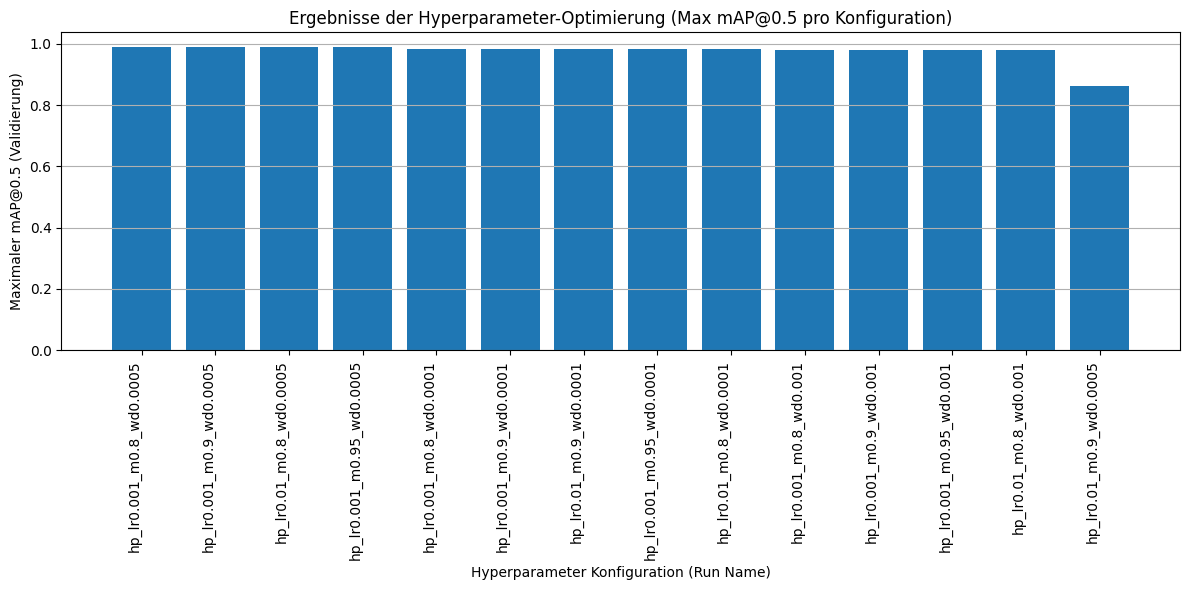

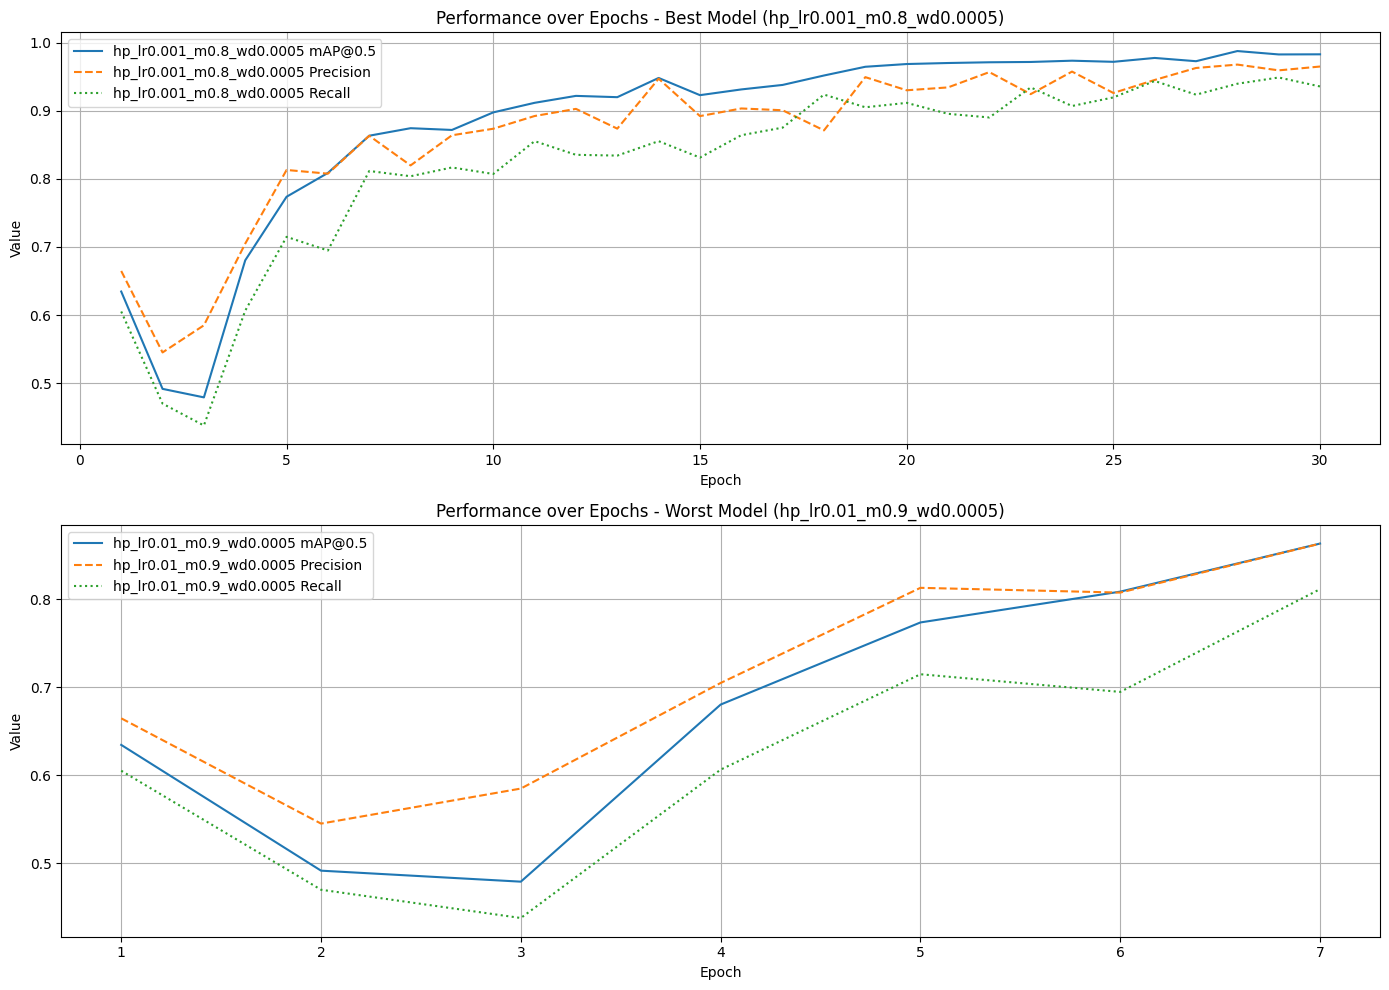

In [ ]:
# Sammle alle Hyperparameter-Tuning CSV-Dateien
# Wir nehmen an, dass die Namen der Runs mit 'hp_' beginnen
hp_runs = glob.glob('./runs/detect/hp_*/results.csv')

print(f"Gefundene Hyperparameter-Runs: {[os.path.basename(os.path.dirname(run)) for run in hp_runs]}")

# DataFrame zum Speichern der Endergebnisse jeder Hyperparameter-Konfiguration
results_summary = []

for run_path in hp_runs:
    try:
        df = pd.read_csv(run_path)
        run_name = os.path.basename(os.path.dirname(run_path))

        # Extrahiere Hyperparameter aus dem Run-Namen (basierend auf Ihrem Namensschema)
        # Annahme: Name ist im Format hp_lrX_mY_wdZ
        parts = run_name.split('_')
        lr = float(parts[2].replace('lr', '')) if len(parts) > 2 and 'lr' in parts[2] else None
        momentum = float(parts[3].replace('m', '')) if len(parts) > 3 and 'm' in parts[3] else None
        weight_decay = float(parts[4].replace('wd', '')) if len(parts) > 4 and 'wd' in parts[4] else None

        # Finde den maximalen mAP50 Wert für diesen Run
        if 'metrics/mAP50(B)' in df.columns:
            max_map50 = df['metrics/mAP50(B)'].max()
            results_summary.append({
                'run_name': run_name,
                'lr0': lr,
                'momentum': momentum,
                'weight_decay': weight_decay,
                'max_mAP50': max_map50
            })
        else:
             print(f"Warnung: 'metrics/mAP50(B)' nicht gefunden in {run_name}")
             results_summary.append({
                'run_name': run_name,
                'lr0': lr,
                'momentum': momentum,
                'weight_decay': weight_decay,
                'max_mAP50': None # Oder ein Standardwert
            })

    except Exception as e:
        print(f"Fehler beim Lesen oder Verarbeiten von {run_path}: {e}")


results_df = pd.DataFrame(results_summary)

# Sortieren, um das beste und schwächste Modell zu finden
if not results_df.empty:
    results_df_sorted = results_df.sort_values(by='max_mAP50', ascending=False).reset_index(drop=True)

    print("\nZusammenfassung der Hyperparameter-Optimierung Ergebnisse:")
    print(results_df_sorted[['run_name', 'lr0', 'momentum', 'weight_decay', 'max_mAP50']].to_string(index=False))

    # Bestes und schwächstes Modell identifizieren
    best_model = results_df_sorted.iloc[0]
    worst_model = results_df_sorted.iloc[-1] # Letzte Zeile nach Sortierung

    print(f"\nBestes Modell (basierend auf max mAP50):")
    print(f"  Run Name: {best_model['run_name']}")
    print(f"  Hyperparameter: lr0={best_model['lr0']}, momentum={best_model['momentum']}, weight_decay={best_model['weight_decay']}")
    print(f"  Max mAP50: {best_model['max_mAP50']:.4f}")

    print(f"\nSchwächstes Modell (basierend auf max mAP50):")
    print(f"  Run Name: {worst_model['run_name']}")
    print(f"  Hyperparameter: lr0={worst_model['lr0']}, momentum={worst_model['momentum']}, weight_decay={worst_model['weight_decay']}")
    print(f"  Max mAP50: {worst_model['max_mAP50']:.4f}")

    # Plotten der mAP50 für alle Runs
    plt.figure(figsize=(12, 6))
    plt.bar(results_df_sorted['run_name'], results_df_sorted['max_mAP50'])
    plt.xlabel('Hyperparameter Konfiguration (Run Name)')
    plt.ylabel('Maximaler mAP@0.5 (Validierung)')
    plt.title('Ergebnisse der Hyperparameter-Optimierung (Max mAP@0.5 pro Konfiguration)')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

    # Optional: Plot der Performance-Metriken über Epochen für das beste und schwächste Modell

    best_run_path = f'./runs/detect/{best_model["run_name"]}/results.csv'
    worst_run_path = f'./runs/detect/{worst_model["run_name"]}/results.csv'

    plt.figure(figsize=(14, 10))

    # Plot best model metrics
    plt.subplot(2, 1, 1)
    try:
        df_best = pd.read_csv(best_run_path)
        plt.plot(df_best['epoch'], df_best['metrics/mAP50(B)'], label=f'{best_model["run_name"]} mAP@0.5')
        plt.plot(df_best['epoch'], df_best['metrics/precision(B)'], label=f'{best_model["run_name"]} Precision', linestyle='--')
        plt.plot(df_best['epoch'], df_best['metrics/recall(B)'], label=f'{best_model["run_name"]} Recall', linestyle=':')
        plt.title(f'Performance over Epochs - Best Model ({best_model["run_name"]})')
        plt.xlabel('Epoch'); plt.ylabel('Value')
        plt.legend(); plt.grid(True)
    except Exception as e:
        print(f"Konnte Daten für bestes Modell {best_model['run_name']} nicht plotten: {e}")


    # Plot worst model metrics
    plt.subplot(2, 1, 2)
    try:
        df_worst = pd.read_csv(worst_run_path)
        plt.plot(df_worst['epoch'], df_worst['metrics/mAP50(B)'], label=f'{worst_model["run_name"]} mAP@0.5')
        plt.plot(df_worst['epoch'], df_worst['metrics/precision(B)'], label=f'{worst_model["run_name"]} Precision', linestyle='--')
        plt.plot(df_worst['epoch'], df_worst['metrics/recall(B)'], label=f'{worst_model["run_name"]} Recall', linestyle=':')
        plt.title(f'Performance over Epochs - Worst Model ({worst_model["run_name"]})')
        plt.xlabel('Epoch'); plt.ylabel('Value')
        plt.legend(); plt.grid(True)
    except Exception as e:
         print(f"Konnte Daten für schwächstes Modell {worst_model['run_name']} nicht plotten: {e}")

    plt.tight_layout()
    plt.show()

else:
    print("Keine Hyperparameter-Tuning Ergebnisse gefunden.")

4. Progressive Grössenstrategie

In [8]:
# Progressive Grössen-Strategie
training_stages = [
    {'imgsz': 320, 'epochs': 20, 'lr0': 0.01, 'name': 'progressive_stage_1'},
    {'imgsz': 416, 'epochs': 30, 'lr0': 0.005, 'name': 'progressive_stage_2'},
    {'imgsz': 640, 'epochs': 50, 'lr0': 0.001, 'name': 'progressive_stage_3'}
]

# Start with the initial model
model = YOLO('yolov8s.pt')

for i, stage in enumerate(training_stages):
    print(f"Training Stage {i+1}: {stage}")

    # Train the current stage
    results = model.train(
        data='../data_small/dog_dataset.yaml',
        # Pass parameters from the stage dictionary
        **stage,
        exist_ok=True
    )

    # Load the best model from the completed stage for the next iteration
    # This starts the next stage with the best weights from the previous one
    if i < len(training_stages) - 1:
        # Get the path to the best model from the completed run
        best_model_path = f'runs/detect/{stage["name"]}/weights/best.pt'
        # Create a new YOLO model instance loaded with these weights
        model = YOLO(best_model_path)
    else:
        # For the last stage, the training is complete
        print("Progressive training completed.")

Training Stage 1: {'imgsz': 320, 'epochs': 20, 'lr0': 0.01, 'name': 'progressive_stage_1'}
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=progressive_stage_1, nbs=64, nms=False, opset=No

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 6.7±12.7 ms, read: 42.8±32.5 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/progressive_stage_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs/detect/progressive_stage_1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.21G      1.428      1.586      1.474          6        320: 100%|██████████| 154/154 [00:14<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]

                   all        231        249      0.701      0.602      0.662      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.46G      1.527      1.443      1.551          4        320: 100%|██████████| 154/154 [00:14<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]

                   all        231        249      0.645       0.59      0.616      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.46G      1.549      1.435      1.552          4        320: 100%|██████████| 154/154 [00:13<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        231        249      0.719      0.711      0.728      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.47G      1.523      1.385      1.537          4        320: 100%|██████████| 154/154 [00:13<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

                   all        231        249      0.709      0.598      0.633      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.51G      1.444      1.262      1.471          4        320: 100%|██████████| 154/154 [00:14<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]

                   all        231        249      0.792      0.759       0.79       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.54G      1.385      1.164      1.428          3        320: 100%|██████████| 154/154 [00:14<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]

                   all        231        249      0.788      0.716      0.773      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.55G       1.31      1.083      1.373          6        320: 100%|██████████| 154/154 [00:13<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.59it/s]

                   all        231        249      0.876      0.792      0.855      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.55G      1.285      1.051      1.368          5        320: 100%|██████████| 154/154 [00:14<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]

                   all        231        249      0.855      0.811      0.838      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.55G      1.249     0.9733      1.343          6        320: 100%|██████████| 154/154 [00:14<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

                   all        231        249       0.87      0.807      0.863      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.58G      1.215     0.9331      1.316          7        320: 100%|██████████| 154/154 [00:13<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]

                   all        231        249      0.893      0.819      0.857      0.566


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.62G      1.122      0.789      1.269          2        320: 100%|██████████| 154/154 [00:15<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

                   all        231        249      0.874      0.791      0.828      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.65G      1.107     0.7516      1.252          2        320: 100%|██████████| 154/154 [00:13<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.51it/s]

                   all        231        249      0.847      0.859      0.866      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.66G      1.044     0.6713      1.198          2        320: 100%|██████████| 154/154 [00:14<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.14it/s]

                   all        231        249      0.863      0.843      0.896      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.75G     0.9848     0.6328       1.17          2        320: 100%|██████████| 154/154 [00:14<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        231        249      0.868      0.851      0.873      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.75G     0.9371     0.5817      1.142          2        320: 100%|██████████| 154/154 [00:13<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]

                   all        231        249      0.849      0.837      0.879      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.75G     0.8857     0.5478      1.117          2        320: 100%|██████████| 154/154 [00:14<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

                   all        231        249      0.861      0.873      0.873      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.75G      0.843     0.5035      1.087          3        320: 100%|██████████| 154/154 [00:14<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

                   all        231        249      0.879      0.843      0.881      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.75G     0.8085     0.4745      1.062          3        320: 100%|██████████| 154/154 [00:14<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]

                   all        231        249      0.905      0.879      0.913      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.75G     0.7593     0.4425      1.035          2        320: 100%|██████████| 154/154 [00:14<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        231        249      0.895      0.858      0.895      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.75G     0.7401     0.4277      1.021          2        320: 100%|██████████| 154/154 [00:14<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]

                   all        231        249       0.89      0.876      0.896      0.672



20 epochs completed in 0.087 hours.
Optimizer stripped from runs/detect/progressive_stage_1/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/progressive_stage_1/weights/best.pt, 22.5MB

Validating runs/detect/progressive_stage_1/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


                   all        231        249       0.89      0.876      0.896      0.672
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/progressive_stage_1
Training Stage 2: {'imgsz': 416, 'epochs': 30, 'lr0': 0.005, 'name': 'progressive_stage_2'}
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=F

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.6±1.0 ms, read: 33.4±29.9 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/progressive_stage_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/progressive_stage_2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.04G      1.001     0.7426      1.259          6        416: 100%|██████████| 154/154 [00:15<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]

                   all        231        249      0.862      0.827       0.88      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.47G       1.09     0.8418      1.316          4        416: 100%|██████████| 154/154 [00:14<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.04it/s]

                   all        231        249      0.891      0.835      0.877      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.47G      1.141     0.9056       1.34          4        416: 100%|██████████| 154/154 [00:13<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]

                   all        231        249      0.846      0.836      0.826      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.47G      1.184     0.9622       1.37          4        416: 100%|██████████| 154/154 [00:13<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]

                   all        231        249       0.81      0.807      0.846      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.47G      1.151     0.9011      1.346          4        416: 100%|██████████| 154/154 [00:13<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.49it/s]

                   all        231        249       0.85      0.707      0.811      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.47G       1.14     0.8969      1.343          3        416: 100%|██████████| 154/154 [00:13<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

                   all        231        249      0.828      0.791      0.833      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.49G       1.09     0.8383      1.306          6        416: 100%|██████████| 154/154 [00:13<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]

                   all        231        249      0.841      0.826       0.88      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.52G      1.066     0.8232      1.289          5        416: 100%|██████████| 154/154 [00:13<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        231        249      0.881      0.815      0.877      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.52G      1.051     0.7938      1.278          6        416: 100%|██████████| 154/154 [00:13<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]

                   all        231        249      0.912      0.811      0.888      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.53G      1.037     0.7766      1.269          7        416: 100%|██████████| 154/154 [00:13<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]

                   all        231        249      0.893      0.801      0.882      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.53G     0.9827      0.733       1.23          5        416: 100%|██████████| 154/154 [00:14<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.17it/s]

                   all        231        249      0.899      0.824       0.91      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.53G      0.977     0.7387      1.234          2        416: 100%|██████████| 154/154 [00:14<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.10it/s]

                   all        231        249      0.905      0.859      0.911      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.53G     0.9635     0.7113      1.229          6        416: 100%|██████████| 154/154 [00:13<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]


                   all        231        249      0.922      0.851      0.909      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.53G     0.9362      0.683      1.205          5        416: 100%|██████████| 154/154 [00:13<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

                   all        231        249      0.899      0.843      0.901      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.53G     0.9416     0.6637      1.211          4        416: 100%|██████████| 154/154 [00:14<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

                   all        231        249      0.904      0.847      0.929      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.53G     0.9054     0.6525      1.187          3        416: 100%|██████████| 154/154 [00:15<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]

                   all        231        249      0.891      0.888      0.914      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.53G     0.8782     0.6269      1.162          5        416: 100%|██████████| 154/154 [00:13<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

                   all        231        249      0.915       0.87      0.928      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.53G     0.8645     0.6006      1.155          7        416: 100%|██████████| 154/154 [00:14<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]

                   all        231        249      0.892      0.864      0.911      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.53G      0.851     0.5878      1.145          3        416: 100%|██████████| 154/154 [00:13<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.96it/s]

                   all        231        249      0.928      0.904      0.938      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.53G     0.8258     0.5703      1.142          3        416: 100%|██████████| 154/154 [00:14<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]

                   all        231        249      0.895      0.895      0.912      0.689


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.53G     0.7186       0.44      1.037          3        416: 100%|██████████| 154/154 [00:14<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]

                   all        231        249      0.884      0.892      0.939      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.53G     0.6907     0.4089      1.019          2        416: 100%|██████████| 154/154 [00:13<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        231        249        0.9      0.867      0.919      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.53G     0.6637     0.3931      1.003          2        416: 100%|██████████| 154/154 [00:13<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

                   all        231        249       0.91       0.93      0.948      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.53G     0.6371     0.3722     0.9977          4        416: 100%|██████████| 154/154 [00:14<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.17it/s]

                   all        231        249      0.915      0.888      0.942      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.53G     0.6151     0.3641     0.9785          2        416: 100%|██████████| 154/154 [00:14<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

                   all        231        249      0.911      0.862      0.924       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.53G     0.5942     0.3488     0.9687          2        416: 100%|██████████| 154/154 [00:13<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.18it/s]

                   all        231        249      0.871      0.884      0.925       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.53G     0.5703     0.3307     0.9566          2        416: 100%|██████████| 154/154 [00:13<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]

                   all        231        249       0.91      0.892      0.939      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.53G      0.543      0.312     0.9381          2        416: 100%|██████████| 154/154 [00:14<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

                   all        231        249      0.915      0.876       0.92      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.53G     0.5395     0.3068     0.9395          2        416: 100%|██████████| 154/154 [00:13<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.15it/s]

                   all        231        249      0.923      0.884      0.946      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.53G     0.5128     0.2959     0.9291          2        416: 100%|██████████| 154/154 [00:14<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]

                   all        231        249      0.894      0.904      0.943      0.747



30 epochs completed in 0.131 hours.
Optimizer stripped from runs/detect/progressive_stage_2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/progressive_stage_2/weights/best.pt, 22.5MB

Validating runs/detect/progressive_stage_2/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


                   all        231        249      0.894      0.904      0.943      0.746
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/progressive_stage_2
Training Stage 3: {'imgsz': 640, 'epochs': 50, 'lr0': 0.001, 'name': 'progressive_stage_3'}
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.7±0.3 ms, read: 71.5±63.7 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/progressive_stage_3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/progressive_stage_3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.77G     0.8156     0.6137      1.258          6        640: 100%|██████████| 154/154 [00:17<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]

                   all        231        249      0.945      0.876      0.949      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.73G     0.8925     0.6782      1.284          4        640: 100%|██████████| 154/154 [00:16<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        231        249      0.877      0.855      0.912      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.73G     0.9417     0.7485      1.298          4        640: 100%|██████████| 154/154 [00:15<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.06it/s]

                   all        231        249       0.88      0.831        0.9      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.73G     0.9827     0.7959      1.335          4        640: 100%|██████████| 154/154 [00:15<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        231        249      0.901      0.807      0.921      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.74G     0.9642     0.7697      1.304          4        640: 100%|██████████| 154/154 [00:15<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        231        249      0.889      0.805      0.888      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.78G     0.9741     0.7755      1.331          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]

                   all        231        249      0.843      0.835      0.904      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.81G     0.9384     0.7171      1.289          6        640: 100%|██████████| 154/154 [00:15<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]

                   all        231        249      0.875      0.843      0.906      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.81G      0.931     0.7211      1.295          5        640: 100%|██████████| 154/154 [00:15<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]

                   all        231        249      0.823      0.875      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.81G     0.9131     0.7089      1.278          6        640: 100%|██████████| 154/154 [00:15<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.35it/s]

                   all        231        249      0.886      0.873      0.935       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.85G     0.9219      0.695      1.283          7        640: 100%|██████████| 154/154 [00:15<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        231        249      0.934      0.811       0.93      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.88G     0.8777     0.6618      1.251          5        640: 100%|██████████| 154/154 [00:15<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]

                   all        231        249      0.893      0.863       0.94      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.92G     0.8776     0.6802      1.261          2        640: 100%|██████████| 154/154 [00:15<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]

                   all        231        249      0.905      0.877      0.929       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.92G     0.8725     0.6726      1.252          6        640: 100%|██████████| 154/154 [00:15<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        231        249      0.878      0.916      0.953      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.92G     0.8499     0.6402      1.236          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        231        249      0.922      0.856      0.939      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.92G     0.8496      0.632      1.236          4        640: 100%|██████████| 154/154 [00:15<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]

                   all        231        249      0.943       0.87      0.947      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.92G     0.8352     0.6233      1.221          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]

                   all        231        249      0.927      0.904      0.953      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.92G       0.81     0.5974      1.195          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.10it/s]

                   all        231        249      0.962      0.896      0.959      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.92G     0.8143     0.6013      1.202          7        640: 100%|██████████| 154/154 [00:15<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        231        249      0.939      0.884      0.956      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.92G     0.7979     0.5877      1.187          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.97it/s]

                   all        231        249      0.943      0.908      0.962      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.92G     0.7863     0.5719      1.191          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        231        249      0.942      0.896      0.953      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.92G     0.7871     0.5861      1.184          7        640: 100%|██████████| 154/154 [00:15<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.50it/s]

                   all        231        249      0.885      0.896      0.953      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.92G     0.7836     0.5687      1.184          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]

                   all        231        249      0.938      0.916      0.974      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.92G     0.7736     0.5612      1.171          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.92it/s]

                   all        231        249       0.89      0.924      0.957      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.92G     0.7485     0.5396      1.155          7        640: 100%|██████████| 154/154 [00:15<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.04it/s]

                   all        231        249      0.951      0.892      0.965      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.92G     0.7341     0.5402      1.149          4        640: 100%|██████████| 154/154 [00:15<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.04it/s]

                   all        231        249      0.964      0.896      0.968      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.92G     0.7244      0.521      1.141          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]

                   all        231        249      0.948       0.88      0.948      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.92G     0.7195     0.5263      1.147          2        640: 100%|██████████| 154/154 [00:15<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.25it/s]

                   all        231        249      0.965      0.904      0.971      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.92G     0.6969     0.4958      1.126          5        640: 100%|██████████| 154/154 [00:15<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]

                   all        231        249      0.953      0.905      0.963      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.92G     0.7045     0.4972      1.126          3        640: 100%|██████████| 154/154 [00:15<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.97it/s]

                   all        231        249      0.938      0.912      0.964      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.92G     0.6888     0.4874      1.115          2        640: 100%|██████████| 154/154 [00:15<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.64it/s]

                   all        231        249      0.919      0.924      0.956      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.92G     0.6783     0.4825      1.103          3        640: 100%|██████████| 154/154 [00:15<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]

                   all        231        249      0.985      0.904      0.959      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.92G      0.672      0.465      1.107          4        640: 100%|██████████| 154/154 [00:15<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]

                   all        231        249      0.957      0.904      0.963      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.92G     0.6584     0.4661        1.1          7        640: 100%|██████████| 154/154 [00:15<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        231        249      0.938      0.908      0.958      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.92G     0.6647     0.4564      1.107          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.01it/s]

                   all        231        249      0.958      0.926      0.961      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.92G      0.636     0.4406      1.086          7        640: 100%|██████████| 154/154 [00:16<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        231        249      0.947       0.92      0.959       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.92G     0.6219     0.4378      1.078          5        640: 100%|██████████| 154/154 [00:15<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.54it/s]

                   all        231        249      0.938       0.91      0.961      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.92G       0.63     0.4388       1.08          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.22it/s]

                   all        231        249      0.948       0.92      0.955       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.92G     0.6222     0.4346      1.078          8        640: 100%|██████████| 154/154 [00:16<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.54it/s]

                   all        231        249      0.949      0.928      0.955      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.92G     0.6024     0.4128      1.062          5        640: 100%|██████████| 154/154 [00:16<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]

                   all        231        249      0.936      0.928      0.961      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.92G     0.5953     0.4212      1.068          2        640: 100%|██████████| 154/154 [00:15<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]

                   all        231        249      0.957      0.902       0.96      0.746


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.92G     0.5048     0.3155     0.9916          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.37it/s]

                   all        231        249      0.945      0.891      0.961      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.92G     0.4863     0.2863     0.9752          4        640: 100%|██████████| 154/154 [00:15<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]

                   all        231        249      0.965        0.9      0.968      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.92G     0.4733     0.2814     0.9668          3        640: 100%|██████████| 154/154 [00:15<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]

                   all        231        249      0.954      0.906      0.966      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.92G     0.4707      0.282     0.9649          2        640: 100%|██████████| 154/154 [00:16<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]


                   all        231        249      0.951      0.929      0.967      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.92G     0.4522     0.2659     0.9459          2        640: 100%|██████████| 154/154 [00:15<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]

                   all        231        249      0.958      0.911      0.962      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.92G      0.434     0.2581     0.9447          3        640: 100%|██████████| 154/154 [00:16<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        231        249      0.912      0.928      0.953      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.92G     0.4262     0.2538     0.9329          2        640: 100%|██████████| 154/154 [00:15<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.39it/s]

                   all        231        249      0.972      0.892      0.958      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.92G     0.4126     0.2474     0.9218          2        640: 100%|██████████| 154/154 [00:14<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]

                   all        231        249      0.971      0.888      0.967      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.92G      0.413     0.2478     0.9319          2        640: 100%|██████████| 154/154 [00:15<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        231        249      0.972        0.9      0.965       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.92G        0.4     0.2377     0.9174          2        640: 100%|██████████| 154/154 [00:15<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.18it/s]

                   all        231        249      0.943      0.927      0.969      0.772



50 epochs completed in 0.241 hours.
Optimizer stripped from runs/detect/progressive_stage_3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/progressive_stage_3/weights/best.pt, 22.5MB

Validating runs/detect/progressive_stage_3/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]


                   all        231        249      0.958      0.911      0.962      0.774
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/progressive_stage_3
Progressive training completed.



Gefundene Progressive Training Runs: ['progressive_stage_1', 'progressive_stage_2', 'progressive_stage_3']


<ipython-input-11-e1817cf9eec5>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(progressive_runs))


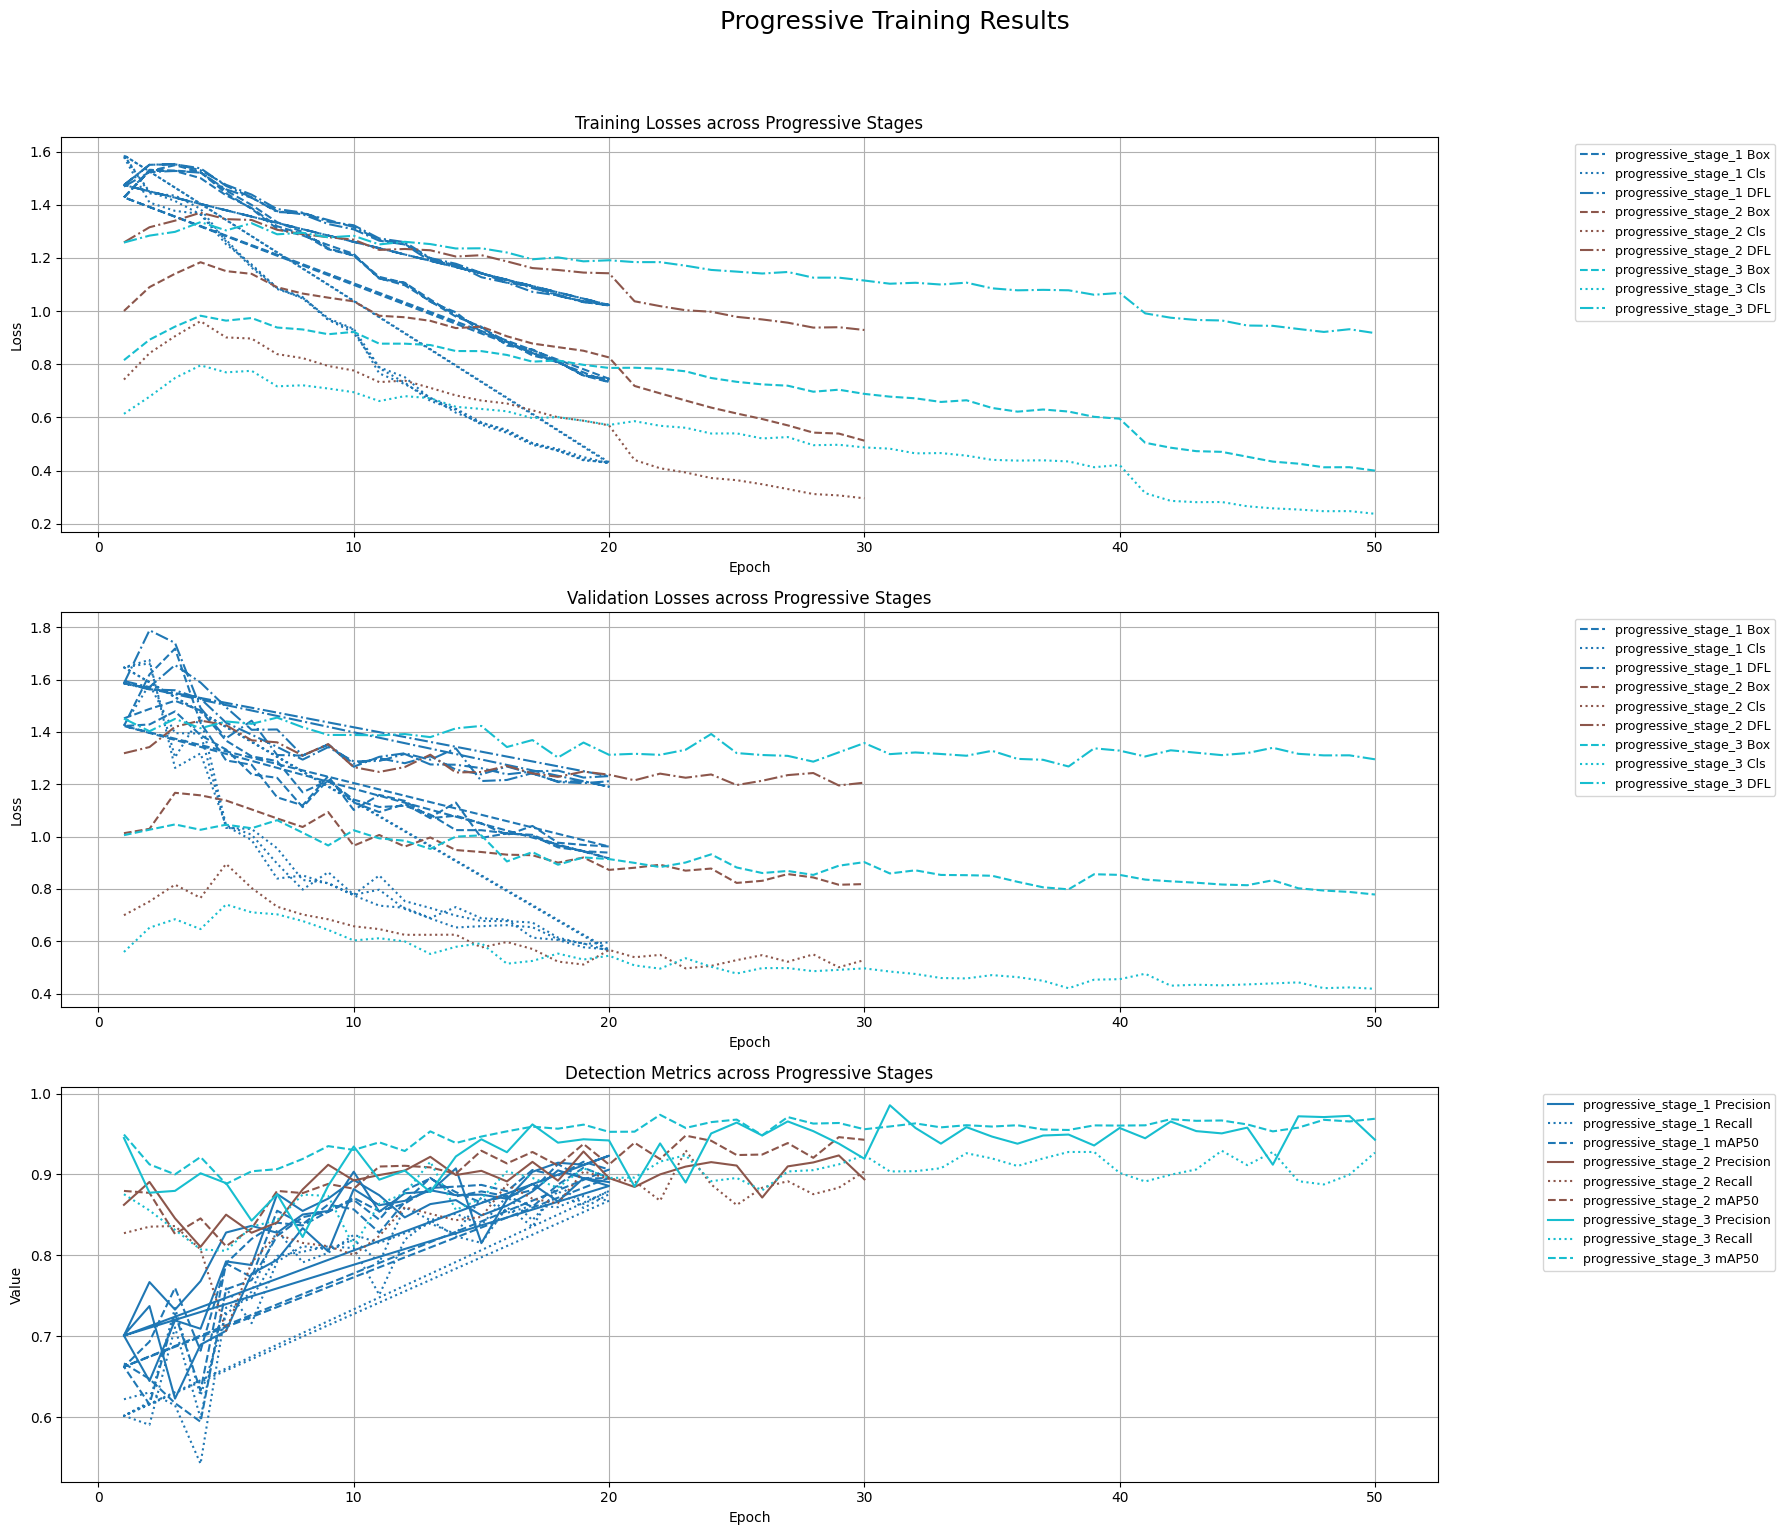


📈 Analyse: Maximaler mAP50 pro Run
  • progressive_stage_1: 0.9156
  • progressive_stage_2: 0.9479
  • progressive_stage_3: 0.9737


In [11]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Suche nach result-Dateien in progressive Training Runs
progressive_runs = sorted(glob.glob('./runs/detect/progressive_stage_*/results.csv'))
print(f"\nGefundene Progressive Training Runs: {[os.path.basename(os.path.dirname(run)) for run in progressive_runs]}")

# Farbpalette
colors = cm.get_cmap('tab10', len(progressive_runs))

# Initialisiere Plot
plt.figure(figsize=(18, 15))

# --------- 1. Trainingsverluste ---------
plt.subplot(3, 1, 1)
for idx, run_path in enumerate(progressive_runs):
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    color = colors(idx)

    if 'train/box_loss' in df.columns:
        plt.plot(df['epoch'], df['train/box_loss'], label=f'{run_name} Box', linestyle='--', color=color)
    if 'train/cls_loss' in df.columns:
        plt.plot(df['epoch'], df['train/cls_loss'], label=f'{run_name} Cls', linestyle=':', color=color)
    if 'train/dfl_loss' in df.columns:
        plt.plot(df['epoch'], df['train/dfl_loss'], label=f'{run_name} DFL', linestyle='-.', color=color)

plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Losses across Progressive Stages')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), ncol=1, fontsize=9)

# --------- 2. Validierungsverluste ---------
plt.subplot(3, 1, 2)
for idx, run_path in enumerate(progressive_runs):
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    color = colors(idx)

    if 'val/box_loss' in df.columns:
        plt.plot(df['epoch'], df['val/box_loss'], label=f'{run_name} Box', linestyle='--', color=color)
    if 'val/cls_loss' in df.columns:
        plt.plot(df['epoch'], df['val/cls_loss'], label=f'{run_name} Cls', linestyle=':', color=color)
    if 'val/dfl_loss' in df.columns:
        plt.plot(df['epoch'], df['val/dfl_loss'], label=f'{run_name} DFL', linestyle='-.', color=color)

plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Validation Losses across Progressive Stages')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), ncol=1, fontsize=9)

# --------- 3. Detection Metrics ---------
plt.subplot(3, 1, 3)
for idx, run_path in enumerate(progressive_runs):
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    color = colors(idx)

    if 'metrics/precision(B)' in df.columns:
        plt.plot(df['epoch'], df['metrics/precision(B)'], label=f'{run_name} Precision', color=color, linestyle='-')
    if 'metrics/recall(B)' in df.columns:
        plt.plot(df['epoch'], df['metrics/recall(B)'], label=f'{run_name} Recall', color=color, linestyle=':')
    if 'metrics/mAP50(B)' in df.columns:
        plt.plot(df['epoch'], df['metrics/mAP50(B)'], label=f'{run_name} mAP50', color=color, linestyle='--')

plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics across Progressive Stages')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), ncol=1, fontsize=9)

# --------- Titel & Layout ---------
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Progressive Training Results', fontsize=18, y=1.02)
plt.show()

# --------- Analyse der besten mAP50 pro Run ---------
print("\n📈 Analyse: Maximaler mAP50 pro Run")
for run_path in progressive_runs:
    try:
        df = pd.read_csv(run_path)
        run_name = os.path.basename(os.path.dirname(run_path))
        if 'metrics/mAP50(B)' in df.columns:
            max_map = df['metrics/mAP50(B)'].max()
            print(f"  • {run_name}: {max_map:.4f}")
        else:
            print(f"  ⚠️  {run_name}: Spalte 'metrics/mAP50(B)' fehlt!")
    except Exception as e:
        print(f"  ❌ Fehler bei {run_path}: {e}")

## Weitere Strategien zur Komplexitätserhöhung

### 5. Ensemble-Methoden
Kombination mehrerer Modelle für bessere Performance

In [12]:
# Ensemble mit verschiedenen YOLO-Modellen
models_to_train = ['yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt']
trained_models = []

for model_name in models_to_train:
    print(f"Training {model_name}...")
    model = YOLO(model_name)
    results = model.train(
        data='../data_small/dog_dataset.yaml',
        epochs=50,
        imgsz=640,
        batch=4,
        name=f'ensemble_{model_name.replace(".pt", "")}',
        exist_ok=True
    )
    trained_models.append(f'runs/detect/ensemble_{model_name.replace(".pt", "")}/weights/best.pt')

print(f"Trainierte Modelle: {trained_models}")

Training yolov8n.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ensemble_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, per

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 3.5±6.6 ms, read: 41.3±36.1 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/ensemble_yolov8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/ensemble_yolov8n
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.682G      1.439        2.2      1.646          2        640: 100%|██████████| 613/613 [00:48<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.29it/s]

                   all        231        249      0.796      0.595      0.702      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.756G      1.572      1.919       1.73          5        640: 100%|██████████| 613/613 [00:44<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.16it/s]

                   all        231        249      0.777      0.615      0.689      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.758G      1.582      1.786      1.736          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.60it/s]

                   all        231        249      0.754      0.616      0.698      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.758G      1.585      1.714      1.737          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.25it/s]

                   all        231        249      0.661      0.606      0.652      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.758G      1.521      1.618      1.683          4        640: 100%|██████████| 613/613 [00:42<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.83it/s]

                   all        231        249      0.792      0.657      0.771      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      0.76G       1.46      1.487      1.628          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.18it/s]

                   all        231        249      0.811      0.775      0.817        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.775G      1.445      1.434      1.607          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]

                   all        231        249      0.789      0.794      0.806      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.777G      1.374      1.328      1.554          5        640: 100%|██████████| 613/613 [00:42<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.64it/s]

                   all        231        249      0.851      0.735       0.84      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.777G      1.358      1.279      1.553          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]

                   all        231        249      0.828      0.736      0.832      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.777G      1.335      1.259      1.527          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]

                   all        231        249      0.823      0.822      0.867      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.777G      1.301      1.202      1.504          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]

                   all        231        249      0.842      0.827      0.863      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.777G      1.262      1.164      1.472          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.78it/s]

                   all        231        249      0.841      0.808      0.883      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.777G      1.258      1.116      1.471          4        640: 100%|██████████| 613/613 [00:43<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]

                   all        231        249       0.91      0.755      0.904      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.777G      1.237        1.1       1.45          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]

                   all        231        249      0.843      0.843      0.896      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.777G      1.246      1.119      1.461          4        640: 100%|██████████| 613/613 [00:43<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]

                   all        231        249      0.874      0.835      0.863      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.777G      1.219      1.044      1.428          1        640: 100%|██████████| 613/613 [00:43<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.45it/s]

                   all        231        249      0.897      0.842      0.897      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.777G      1.196      1.036      1.415          3        640: 100%|██████████| 613/613 [00:42<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]

                   all        231        249      0.894      0.835      0.918      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.777G      1.159      0.981      1.388          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]

                   all        231        249      0.887      0.823      0.894      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.777G      1.159     0.9685      1.384          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]

                   all        231        249      0.927      0.835      0.933      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.777G       1.14     0.9743      1.374          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.06it/s]

                   all        231        249      0.882      0.843      0.906      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.777G      1.131     0.9317      1.373          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]

                   all        231        249      0.865      0.851      0.919       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.777G      1.105        0.9      1.359          4        640: 100%|██████████| 613/613 [00:43<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.95it/s]

                   all        231        249      0.919      0.831      0.916      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.777G      1.105     0.9203      1.356          7        640: 100%|██████████| 613/613 [00:43<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]

                   all        231        249      0.899        0.9      0.945      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.777G      1.093     0.9065      1.354          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.02it/s]

                   all        231        249       0.89      0.878      0.933      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.777G      1.093     0.8806      1.345          8        640: 100%|██████████| 613/613 [00:43<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]

                   all        231        249      0.895      0.835      0.915      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.795G      1.052     0.8504      1.315          7        640: 100%|██████████| 613/613 [00:43<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]

                   all        231        249      0.919      0.884      0.949      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.807G      1.063     0.8496      1.328          8        640: 100%|██████████| 613/613 [00:43<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.05it/s]

                   all        231        249       0.93      0.867      0.956      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.809G      1.037     0.8068      1.299          2        640: 100%|██████████| 613/613 [00:43<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.62it/s]

                   all        231        249      0.917       0.89      0.955      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.826G     0.9996     0.7754      1.276          6        640: 100%|██████████| 613/613 [00:43<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]

                   all        231        249      0.923      0.866       0.95      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.826G      1.004     0.7751      1.275          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]

                   all        231        249      0.919      0.851      0.952      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.826G     0.9847     0.7633      1.273          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.24it/s]

                   all        231        249      0.913      0.884      0.951      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.826G     0.9782     0.7435      1.268          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.02it/s]


                   all        231        249      0.926      0.859      0.945      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.826G     0.9649     0.7391      1.251          5        640: 100%|██████████| 613/613 [00:43<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.66it/s]

                   all        231        249      0.915      0.863       0.95      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.826G     0.9664     0.7381      1.261          4        640: 100%|██████████| 613/613 [00:43<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.94it/s]

                   all        231        249      0.896      0.902      0.954      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.826G     0.9518     0.7313      1.241         10        640: 100%|██████████| 613/613 [00:43<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.90it/s]

                   all        231        249      0.941      0.889      0.959      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.826G     0.9107     0.6848      1.225          8        640: 100%|██████████| 613/613 [00:43<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]

                   all        231        249      0.914      0.901      0.965      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.826G     0.9189     0.7055      1.228          5        640: 100%|██████████| 613/613 [00:43<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]

                   all        231        249      0.912       0.92      0.961      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.826G     0.9013     0.6964      1.219          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.76it/s]

                   all        231        249      0.914      0.896      0.969      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.826G     0.8855     0.6616      1.202          5        640: 100%|██████████| 613/613 [00:43<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]

                   all        231        249      0.912      0.876      0.952      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.826G     0.8667     0.6546      1.201          2        640: 100%|██████████| 613/613 [00:43<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.73it/s]

                   all        231        249      0.938      0.904      0.972      0.735


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.826G      0.774     0.4797      1.131          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.25it/s]

                   all        231        249      0.935      0.888      0.963      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.826G     0.7598      0.462      1.115          4        640: 100%|██████████| 613/613 [00:43<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]

                   all        231        249      0.971      0.888      0.969      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.826G     0.7432     0.4521      1.104          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]

                   all        231        249      0.946      0.888       0.97      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.826G     0.7265     0.4375      1.103          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]

                   all        231        249      0.907      0.932      0.975      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.826G     0.6933      0.416      1.078          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


                   all        231        249       0.93      0.907      0.974      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.826G     0.6889     0.4041      1.076          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.68it/s]

                   all        231        249      0.946      0.907      0.973      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.826G     0.6731     0.4091      1.071          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]

                   all        231        249      0.894      0.952      0.976      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.826G      0.652     0.3845      1.052          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]

                   all        231        249      0.942      0.915      0.979      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.826G     0.6416      0.391      1.045          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.85it/s]

                   all        231        249      0.906       0.94      0.978      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.826G     0.6314     0.3729      1.038          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]

                   all        231        249      0.908       0.94      0.977      0.754



50 epochs completed in 0.631 hours.
Optimizer stripped from runs/detect/ensemble_yolov8n/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/ensemble_yolov8n/weights/best.pt, 6.2MB

Validating runs/detect/ensemble_yolov8n/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.88it/s]


                   all        231        249      0.909       0.94      0.977      0.754
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/ensemble_yolov8n
Training yolov8s.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_de

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.1±0.9 ms, read: 60.1±56.5 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/ensemble_yolov8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/ensemble_yolov8s
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.26G      1.518      1.936      1.694          2        640: 100%|██████████| 613/613 [00:47<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 14.07it/s]

                   all        231        249      0.683      0.522      0.619      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.67G      1.707      1.885      1.859          5        640: 100%|██████████| 613/613 [00:45<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.05it/s]

                   all        231        249      0.679      0.554      0.583      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.69G       1.67       1.85      1.821          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.46it/s]

                   all        231        249      0.713      0.618      0.665      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.73G      1.649      1.769      1.809          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.93it/s]

                   all        231        249      0.687      0.652      0.671      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.74G       1.58      1.653      1.744          4        640: 100%|██████████| 613/613 [00:45<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]

                   all        231        249      0.714      0.722      0.747      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.75G      1.494      1.535      1.692          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]

                   all        231        249      0.825      0.759      0.807      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.75G      1.458       1.44      1.647          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.71it/s]

                   all        231        249      0.856      0.764      0.842      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.75G      1.407      1.332      1.603          5        640: 100%|██████████| 613/613 [00:44<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]

                   all        231        249      0.828      0.747      0.813      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.75G      1.367       1.29      1.572          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.50it/s]

                   all        231        249      0.849      0.768      0.854      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.76G      1.368      1.263      1.565          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]

                   all        231        249      0.815      0.859      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.78G      1.319      1.216      1.534          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.95it/s]


                   all        231        249      0.894      0.783      0.854      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.78G      1.273      1.188      1.506          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


                   all        231        249       0.87      0.804      0.861      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.78G      1.265      1.114      1.502          4        640: 100%|██████████| 613/613 [00:44<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]

                   all        231        249      0.874      0.807      0.889      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.78G      1.243      1.092      1.479          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]

                   all        231        249      0.876      0.853      0.892      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.78G      1.256      1.093      1.487          4        640: 100%|██████████| 613/613 [00:45<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.44it/s]

                   all        231        249      0.853      0.861      0.862      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.78G      1.208      1.032       1.45          1        640: 100%|██████████| 613/613 [00:43<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]

                   all        231        249      0.871      0.859      0.886      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.78G      1.198      1.022      1.439          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]

                   all        231        249      0.907      0.863      0.902      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.78G       1.17      0.985      1.419          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.99it/s]

                   all        231        249      0.884      0.876      0.891      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.78G      1.156     0.9561      1.413          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.04it/s]

                   all        231        249      0.889      0.871       0.92      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.78G      1.148     0.9522      1.396          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]

                   all        231        249      0.892      0.894      0.907       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.78G      1.134     0.9257      1.404          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.29it/s]

                   all        231        249      0.911      0.847      0.911      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.78G      1.114     0.9062      1.372          4        640: 100%|██████████| 613/613 [00:44<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.49it/s]

                   all        231        249      0.902      0.859       0.92      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.78G      1.111     0.8899      1.378          7        640: 100%|██████████| 613/613 [00:45<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.83it/s]

                   all        231        249        0.9      0.896      0.919       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.78G       1.09     0.8851      1.373          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]

                   all        231        249      0.925      0.863      0.934      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.78G      1.082      0.867      1.358          8        640: 100%|██████████| 613/613 [00:45<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]

                   all        231        249      0.919      0.843      0.936      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.78G      1.058      0.846      1.337          7        640: 100%|██████████| 613/613 [00:44<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.07it/s]

                   all        231        249      0.858      0.867      0.922      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.78G      1.027     0.8328      1.327          8        640: 100%|██████████| 613/613 [00:44<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.35it/s]


                   all        231        249      0.828      0.876      0.909      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.78G      1.007     0.7969      1.306          2        640: 100%|██████████| 613/613 [00:44<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.82it/s]

                   all        231        249      0.894      0.879      0.932      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.78G     0.9786     0.7713      1.284          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]

                   all        231        249      0.908      0.876       0.94      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.78G      0.969     0.7497      1.278          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]

                   all        231        249      0.903      0.896      0.948      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.78G     0.9625     0.7302      1.274          2        640: 100%|██████████| 613/613 [00:45<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]

                   all        231        249       0.95      0.837      0.944        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.78G     0.9452     0.7257      1.269          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.16it/s]

                   all        231        249      0.892        0.9      0.934      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.78G     0.9329     0.7103      1.251          5        640: 100%|██████████| 613/613 [00:44<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.26it/s]

                   all        231        249      0.916      0.916      0.955      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.78G     0.9248     0.7003      1.257          4        640: 100%|██████████| 613/613 [00:44<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.83it/s]

                   all        231        249      0.925      0.888      0.947      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.78G     0.9009       0.68       1.23         10        640: 100%|██████████| 613/613 [00:44<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]

                   all        231        249      0.915      0.909      0.953      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.78G     0.8759     0.6477      1.211          8        640: 100%|██████████| 613/613 [00:44<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]

                   all        231        249      0.892      0.928      0.958      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.78G     0.8859     0.6709      1.217          5        640: 100%|██████████| 613/613 [00:45<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]

                   all        231        249      0.917      0.908      0.955      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.78G     0.8746     0.6477      1.213          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.04it/s]


                   all        231        249       0.88      0.912      0.955      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.78G      0.837     0.6084      1.188          5        640: 100%|██████████| 613/613 [00:43<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.03it/s]

                   all        231        249      0.933      0.892      0.961      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.78G     0.8227     0.6101       1.18          2        640: 100%|██████████| 613/613 [00:43<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.79it/s]

                   all        231        249       0.92      0.922      0.966      0.719


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.78G      0.717     0.4428      1.101          2        640: 100%|██████████| 613/613 [00:45<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.16it/s]

                   all        231        249      0.912      0.913      0.959      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.78G     0.7097     0.4238      1.097          4        640: 100%|██████████| 613/613 [00:45<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]

                   all        231        249      0.917      0.926      0.964      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.78G     0.6813     0.4069      1.076          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]

                   all        231        249      0.922      0.954      0.976      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.78G     0.6649     0.3863      1.074          2        640: 100%|██████████| 613/613 [00:44<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]

                   all        231        249      0.919      0.909      0.965      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.78G     0.6326     0.3708       1.05          2        640: 100%|██████████| 613/613 [00:43<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]

                   all        231        249      0.921      0.912      0.969       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.78G      0.631     0.3667      1.053          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.65it/s]

                   all        231        249      0.956      0.896      0.973      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.78G     0.6185     0.3579      1.044          2        640: 100%|██████████| 613/613 [00:44<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.19it/s]

                   all        231        249      0.935      0.916      0.976      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.78G     0.5898      0.341      1.028          2        640: 100%|██████████| 613/613 [00:43<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.81it/s]

                   all        231        249      0.952      0.908      0.973      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.78G     0.5833     0.3426      1.021          2        640: 100%|██████████| 613/613 [00:43<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.70it/s]

                   all        231        249      0.916       0.92      0.969      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.78G     0.5792     0.3332      1.018          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]

                   all        231        249      0.923      0.921      0.968      0.746



50 epochs completed in 0.651 hours.
Optimizer stripped from runs/detect/ensemble_yolov8s/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/ensemble_yolov8s/weights/best.pt, 22.5MB

Validating runs/detect/ensemble_yolov8s/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.75it/s]


                   all        231        249      0.923       0.92      0.968      0.746
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/ensemble_yolov8s
Training yolov8m.pt...


KeyboardInterrupt: 

Gefundene Ensemble-Runs: ['ensemble_yolov8n', 'ensemble_yolov8s']


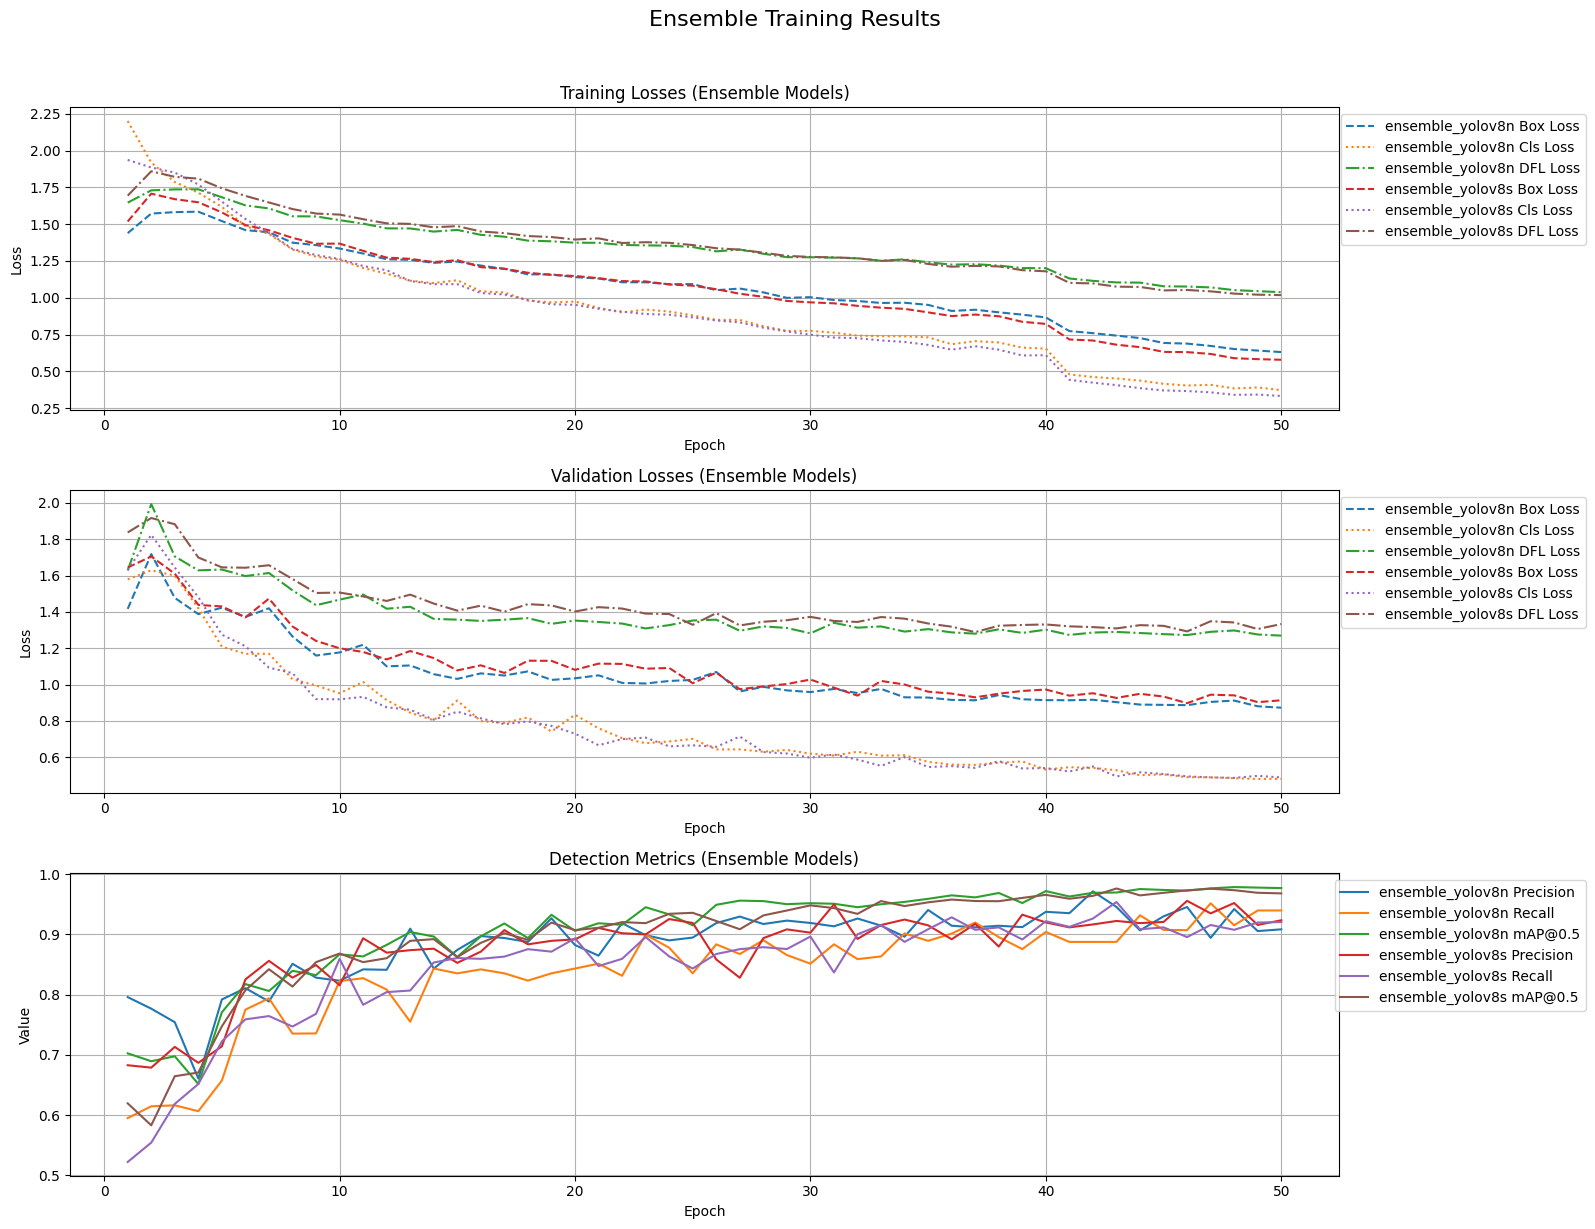

In [2]:
import pandas as pd
import glob
import os

# Plotte die Ergebnisse der Ensemble-Modelle aus dem runs-Verzeichnis

import matplotlib.pyplot as plt

# Finde alle Ensemble-Runs
ensemble_csvs = glob.glob('./runs/detect/ensemble_*/results.csv')
print(f"Gefundene Ensemble-Runs: {[os.path.basename(os.path.dirname(run)) for run in ensemble_csvs]}")

plt.figure(figsize=(16, 12))

# Plot Training Losses
plt.subplot(3, 1, 1)
for run_path in ensemble_csvs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['train/box_loss'], label=f'{run_name} Box Loss', linestyle='--')
    plt.plot(df['epoch'], df['train/cls_loss'], label=f'{run_name} Cls Loss', linestyle=':')
    plt.plot(df['epoch'], df['train/dfl_loss'], label=f'{run_name} DFL Loss', linestyle='-.')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses (Ensemble Models)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)

# Plot Validation Losses
plt.subplot(3, 1, 2)
for run_path in ensemble_csvs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['val/box_loss'], label=f'{run_name} Box Loss', linestyle='--')
    plt.plot(df['epoch'], df['val/cls_loss'], label=f'{run_name} Cls Loss', linestyle=':')
    plt.plot(df['epoch'], df['val/dfl_loss'], label=f'{run_name} DFL Loss', linestyle='-.')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses (Ensemble Models)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)

# Plot Detection Metrics
plt.subplot(3, 1, 3)
for run_path in ensemble_csvs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['metrics/precision(B)'], label=f'{run_name} Precision')
    plt.plot(df['epoch'], df['metrics/recall(B)'], label=f'{run_name} Recall')
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label=f'{run_name} mAP@0.5')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Detection Metrics (Ensemble Models)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle('Ensemble Training Results', fontsize=16, y=1.02)
plt.show()

In [ ]:
# Ensemble Prediction Funktion
def ensemble_predict(image_path, model_paths, conf_threshold=0.25):
    """
    Ensemble Prediction mit mehreren Modellen
    """
    all_predictions = []

    for model_path in model_paths:
        if os.path.exists(model_path):
            model = YOLO(model_path)
            results = model(image_path, conf=conf_threshold)
            all_predictions.append(results[0])

    return all_predictions

# Test mit einem Bild (falls verfügbar)
test_images = glob.glob('../data_small/valid/images/*.jpg')[:5]
if test_images and all(os.path.exists(model) for model in trained_models):
    for img in test_images:
        predictions = ensemble_predict(img, trained_models)
        print(f"Ensemble predictions für {os.path.basename(img)}: {len(predictions)} Modelle")

### 6. Erweiterte Augmentationen
Stärkere und vielfältigere Augmentationen für bessere Generalisierung

In [ ]:
def get_advanced_augmentation():
    """
    Erweiterte Augmentationen für noch mehr Varianz
    """
    return A.Compose([
        # Geometrische Transformationen
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Affine(
            scale=(0.7, 1.3),
            translate_percent=(-0.2, 0.2),
            rotate=(-25, 25),
            shear=(-10, 10),
            p=0.7
        ),
        A.Perspective(scale=(0.05, 0.1), p=0.3),
        A.ElasticTransform(alpha=1, sigma=50, p=0.2),

        # Farb- und Beleuchtungsänderungen
        A.RandomBrightnessContrast(
            brightness_limit=0.3,
            contrast_limit=0.3,
            p=0.7
        ),
        A.HueSaturationValue(
            hue_shift_limit=20,
            sat_shift_limit=25,
            val_shift_limit=20,
            p=0.5
        ),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.4),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),
        A.CLAHE(clip_limit=2.0, p=0.3),

        # Rauschen und Unschärfe
        A.OneOf([
            A.GaussNoise(var_limit=(10, 50), p=1.0),
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
            A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=1.0),
        ], p=0.4),

        A.OneOf([
            A.GaussianBlur(blur_limit=5, p=1.0),
            A.MotionBlur(blur_limit=5, p=1.0),
            A.MedianBlur(blur_limit=3, p=1.0),
        ], p=0.3),

        # Wettereffekte
        A.OneOf([
            A.RandomRain(p=1.0),
            A.RandomSnow(p=1.0),
            A.RandomFog(p=1.0),
            A.RandomSunFlare(p=1.0),
        ], p=0.2),

        # Pixelmanipulation
        A.Downscale(scale_min=0.7, scale_max=0.9, p=0.2),
        A.ImageCompression(quality_lower=60, quality_upper=100, p=0.3),

    ], bbox_params=A.BboxParams(
        format='yolo',
        label_fields=['class_labels'],
        min_visibility=0.2  # Reduziert für stärkere Augmentationen
    ))

# Erstelle stark augmentiertes Dataset
print("Erstelle stark augmentiertes Dataset...")
augment_dataset(
    '../data_small/train',
    '../data_small/train_heavy_augmented',
    num_augmentations=5
)

# Aktualisiere YAML für stark augmentierte Daten
yaml_content_heavy = {
    'path': os.path.abspath('../data_small'),
    'train': 'train_heavy_augmented/images',
    'val': 'valid/images',
    'nc': 1,
    'names': ['dog']
}

with open('../data_small/dog_dataset_heavy_aug.yaml', 'w') as f:
    yaml.dump(yaml_content_heavy, f, default_flow_style=False)

### 7. Multi-Scale Training
Training mit zufälligen Bildgrößen während des Trainings

In [ ]:
# Multi-Scale Training mit YOLOv8
model = YOLO('yolov8m.pt')  # Größeres Modell für mehr Komplexität

results = model.train(
    data='../data_small/dog_dataset_heavy_aug.yaml',
    epochs=100,
    imgsz=640,
    batch=4,
    # Multi-Scale Training Parameter
    rect=False,  # Deaktiviert rechteckige Inferenz für Multi-Scale
    mosaic=1.0,  # Mosaic Augmentation
    mixup=0.15,  # MixUp Augmentation
    copy_paste=0.3,  # Copy-Paste Augmentation
    # Erweiterte Augmentationen
    degrees=20,  # Rotation
    translate=0.2,  # Translation
    scale=0.9,  # Skalierung
    shear=10,  # Scherung
    perspective=0.0003,  # Perspektive
    flipud=0.1,  # Vertical flip
    fliplr=0.5,  # Horizontal flip
    hsv_h=0.015,  # Hue
    hsv_s=0.7,  # Saturation
    hsv_v=0.4,  # Value
    # Optimizer Settings
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    # Loss weights
    box=7.5,
    cls=0.5,
    dfl=1.5,
    name='multi_scale_complex',
    exist_ok=True
)

### 8. Knowledge Distillation
Verwendung eines großen Teacher-Modells zur Verbesserung eines kleineren Student-Modells

In [ ]:
# Teacher-Student Training (vereinfachte Version)
# 1. Trainiere ein großes Teacher-Modell
print("Training Teacher Model (YOLOv8x)...")
teacher_model = YOLO('yolov8x.pt')
teacher_results = teacher_model.train(
    data='../data_small/dog_dataset_heavy_aug.yaml',
    epochs=50,
    imgsz=640,
    batch=2,  # Kleinere Batch für größeres Modell
    name='teacher_model',
    exist_ok=True
)

# 2. Verwende Teacher für Pseudo-Labels auf zusätzlichen Daten
# (Simuliert Knowledge Distillation)
print("Training Student Model mit Teacher-Guidance...")
student_model = YOLO('yolov8s.pt')
student_results = student_model.train(
    data='../data_small/dog_dataset_heavy_aug.yaml',
    epochs=80,
    imgsz=640,
    batch=4,
    # Optimierte Parameter basierend auf Teacher
    lr0=0.005,  # Niedrigere Learning Rate
    patience=20,  # Mehr Geduld
    name='student_with_teacher',
    exist_ok=True
)

### 9. Architektur-Modifikationen
Anpassungen der Modellarchitektur für spezifische Anforderungen

In [ ]:
# Test verschiedener YOLO-Architekturen
architectures = {
    'yolov8n': 'yolov8n.pt',
    'yolov8s': 'yolov8s.pt',
    'yolov8m': 'yolov8m.pt',
    'yolov8l': 'yolov8l.pt',
    'yolov8x': 'yolov8x.pt'
}

architecture_results = {}

for arch_name, model_path in architectures.items():
    print(f"Training {arch_name}...")

    # Angepasste Parameter je nach Modellgröße
    if 'x' in arch_name or 'l' in arch_name:
        batch_size = 2
        epochs = 30
    elif 'm' in arch_name:
        batch_size = 3
        epochs = 40
    else:
        batch_size = 4
        epochs = 50

    model = YOLO(model_path)
    results = model.train(
        data='../data_small/dog_dataset_heavy_aug.yaml',
        epochs=epochs,
        imgsz=640,
        batch=batch_size,
        name=f'architecture_test_{arch_name}',
        exist_ok=True,
        patience=15
    )

    # Speichere Ergebnisse für Vergleich
    architecture_results[arch_name] = {
        'mAP50': results.results_dict.get('metrics/mAP50(B)', 0),
        'precision': results.results_dict.get('metrics/precision(B)', 0),
        'recall': results.results_dict.get('metrics/recall(B)', 0)
    }

# Vergleiche Architekturen
print("\nArchitektur-Vergleich:")
for arch, metrics in architecture_results.items():
    print(f"{arch}: mAP50={metrics['mAP50']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}")

### 10. Test-Time Augmentation (TTA)
Augmentationen während der Inferenz für bessere Ergebnisse

In [ ]:
def test_time_augmentation(model, image_path, augmentations=5):
    """
    Test-Time Augmentation für bessere Predictions
    """
    import cv2
    import numpy as np
    from copy import deepcopy

    # Lade Original-Bild
    original_image = cv2.imread(image_path)
    if original_image is None:
        return None

    all_predictions = []

    # Original Prediction
    result = model(image_path, conf=0.25)
    all_predictions.append(result[0])

    # Augmentierte Predictions
    for i in range(augmentations):
        # Zufällige Augmentationen
        augmented = original_image.copy()

        # Horizontal Flip
        if np.random.random() > 0.5:
            augmented = cv2.flip(augmented, 1)

        # Rotation
        angle = np.random.uniform(-15, 15)
        height, width = augmented.shape[:2]
        center = (width // 2, height // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        augmented = cv2.warpAffine(augmented, rotation_matrix, (width, height))

        # Brightness
        brightness = np.random.uniform(0.8, 1.2)
        augmented = cv2.convertScaleAbs(augmented, alpha=brightness, beta=0)

        # Speichere temporär und predicte
        temp_path = f'temp_aug_{i}.jpg'
        cv2.imwrite(temp_path, augmented)

        result = model(temp_path, conf=0.25)
        all_predictions.append(result[0])

        # Lösche temporäre Datei
        os.remove(temp_path)

    return all_predictions

# Test TTA mit bestem Modell
best_model_path = 'runs/detect/multi_scale_complex/weights/best.pt'
if os.path.exists(best_model_path):
    model = YOLO(best_model_path)

    # Test auf Validierungsbildern
    val_images = glob.glob('../data_small/valid/images/*.jpg')[:3]

    for img_path in val_images:
        print(f"\nTTA für {os.path.basename(img_path)}:")
        tta_results = test_time_augmentation(model, img_path)
        if tta_results:
            print(f"Anzahl Predictions: {len(tta_results)}")
            # Hier könnte man die Predictions ensemble-artig kombinieren
else:
    print("Bestes Modell nicht gefunden. Trainiere zuerst ein Modell.")

### Overfitting-Test nach Karpathy's Recipe

Im nächsten Schritt wird gezielt ein Overfitting-Test durchgeführt. Dazu wird ein sehr kleines Trainingsset erstellt und verschiedene YOLO-Modelle mehrfach darauf trainiert. Ziel ist es zu überprüfen, ob die Modelle in der Lage sind, das kleine Datenset nahezu perfekt zu lernen (Overfitting), was ein wichtiger Debugging-Schritt für Trainingspipelines ist.

In [ ]:
# Overfitting-Test nach Karpathy's Recipe

# 1. Nutze ein sehr kleines Trainingsset (z.B. 10 Bilder)
def create_tiny_overfit_set(src_root='../data', dst_root='../data_tiny', n_train=10, n_val=5):
    for split, n in zip(['train', 'valid'], [n_train, n_val]):
        src_dir = os.path.join(src_root, split)
        dst_dir = os.path.join(dst_root, split)
        images_dir = os.path.join(dst_dir, 'images')
        labels_dir = os.path.join(dst_dir, 'labels')
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)
        imgs = glob.glob(f"{src_dir}/*.jpg") + glob.glob(f"{src_dir}/*.png")
        sample = imgs if len(imgs) < n else random.sample(imgs, n)
        for img in sample:
            base = os.path.basename(img)
            name, _ = os.path.splitext(base)
            txt = os.path.join(src_dir, name + '.txt')
            shutil.copy(img, os.path.join(images_dir, base))
            if os.path.isfile(txt):
                shutil.copy(txt, os.path.join(labels_dir, name + '.txt'))

create_tiny_overfit_set()

# 2. YAML für tiny set
yaml_tiny = {
    'path': os.path.abspath('../data_tiny'),
    'train': 'train/images',
    'val': 'valid/images',
    'nc': 1,
    'names': ['dog']
}
with open('../data_tiny/dog_dataset_tiny.yaml', 'w') as f:
    yaml.dump(yaml_tiny, f, default_flow_style=False)

# 3. Verschiedene Modelle ausprobieren und mehrfach trainieren
models = ['yolov8n.pt', 'yolov8s.pt']
results_overfit = {}

for model_name in models:
    print(f"\nOverfit-Test mit {model_name}")
    scores = []
    for run in range(3):  # Mehrfaches Training zur Evaluation
        model = YOLO(model_name)
        results = model.train(
            data='../data_tiny/dog_dataset_tiny.yaml',
            imgsz=640,
            epochs=100,
            batch=2,
            name=f'overfit_{model_name.replace(".pt","")}_run{run+1}',
            exist_ok=True,
            patience=30,
            verbose=False
        )
        mAP = results.results_dict.get('metrics/mAP50(B)', 0)
        scores.append(mAP)
        print(f"Run {run+1}: mAP50={mAP:.3f}")
    results_overfit[model_name] = scores

print("\nOverfit-Ergebnisse (mAP50 pro Run):")
for model_name, scores in results_overfit.items():
    print(f"{model_name}: {scores}")